# metaBGC
---
Mining for biosynthetic gene clusters in metagenomic datasets

## Loading packages and initialization

In [1]:
library(tidyverse)
library(tidylog)
library(printr)
library(patchwork)
library(reshape2)
library(Rtsne)
library(vegan)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘tidylog’


The following objects are masked from ‘package:dplyr’:

    add_count, add_tally, anti_join, count, distinct, distinct_all,
    distinct_at, distinct_if, filter, filter_all, filter_at, filter_if,
    full_join, group_by, group_by_all, group_by_at, group_by_if,
    inner_join, left_join, mutate, mutate_all, mutate_at, mutate_if,
    relocate, rename, rename_all, rename_at, rename_if, rename_with,
    right_join, sample_frac, sample_n, select, select_all, select_at,
    select_if, semi_join, slice, slice_head, slice_max, slice_min,
    slice_sample, slice_tail, summarise, summa

In [2]:
# Constants
myalpha = 0.8
abundance_cutoff = 0.01
top_taxa_cutoff = 10
human_taxa = c("Homo", "Homo sapiens")

# Plot size
options(repr.plot.width=12, repr.plot.height=12)

## Loading the data

In [3]:
meta = read_tsv("projects.tsv") %>% filter(flag == "yes") %>% select(-flag)
meta


── Column specification ────────────────────────────────────────────────────────
cols(
  accession = col_character(),
  project = col_character(),
  description = col_character(),
  flag = col_character()
)


filter: no rows removed

select: dropped one variable (flag)



accession   project  description                              
1  PRJNA472006 Nose     Human Skin Metagenome (Nose)             
2  PRJDB6156   Osaka    Osaka Bay Metatranscriptome (Marine)     
3  PRJEB13831  Sewage   Global Sewage Project (Monoisolate)      
4  PRJNA340165 Tonga    Tonga Trench (Sediment)                  
5  PRJNA489681 Skin     Human Skin Metagenome (atopic dermatitis)
6  PRJNA624223 COVID19  Human Stool Metagenome (COVID-19)        
7  PRJNA629394 Mangrove Mangrove Metagenome (Sediment)           
8  PRJNA631351 Plumbing Hospital Plumbing Metagenome             
9  PRJNA587635 Biofilm  Hospital Plumbing Sink Biofilm Metagenome
10 PRJNA475599 UC       Human Stool Metagenome (UC)

In [4]:
mylevels = c("Nose", "Skin", "UC", "COVID19", "Sewage", "Plumbing", "Biofilm", "Osaka", "Mangrove", "Tonga")
mylevels

[1] "Nose"     "Skin"     "UC"       "COVID19"  "Sewage"   "Plumbing"
 [7] "Biofilm"  "Osaka"    "Mangrove" "Tonga"

In [5]:
projects = read_tsv("tables/samples.tsv") %>% rename (accession = project) %>% inner_join(meta) %>% mutate (project = factor(project, levels = mylevels))
head(projects)


── Column specification ────────────────────────────────────────────────────────
cols(
  sample = col_character(),
  project = col_character()
)


rename: renamed one variable (accession)

Joining, by = "accession"

inner_join: added 2 columns (project, description)

            > rows only in x  (  0)

            > rows only in y  (  0)

            > matched rows     118

            >                 =====

            > rows total       118

mutate: converted 'project' from character to factor (0 new NA)



sample    accession project description                         
1 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
2 DRR099941 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
3 DRR099942 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
4 DRR099943 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
5 DRR099944 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
6 DRR099945 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)

In [6]:
reads = read_tsv("tables/filtered.reads.tsv")
head(reads)


── Column specification ────────────────────────────────────────────────────────
cols(
  sample = col_character(),
  filtered = col_double()
)




sample    filtered
1 DRR099940 2649580 
2 DRR099941 7382595 
3 DRR099942 5239370 
4 DRR099943 5813994 
5 DRR099944 6377636 
6 DRR099945 2581855

In [7]:
reads2 = reads %>% inner_join(projects)
head(reads2)

Joining, by = "sample"

inner_join: added 3 columns (accession, project, description)

            > rows only in x  ( 0)

            > rows only in y  (43)

            > matched rows     75

            >                 ====

            > rows total       75



sample    filtered accession project description                         
1 DRR099940 2649580  PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
2 DRR099941 7382595  PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
3 DRR099942 5239370  PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
4 DRR099943 5813994  PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
5 DRR099944 6377636  PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
6 DRR099945 2581855  PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)

In [8]:
samples = reads2 %>% select(-filtered)
head(samples)

select: dropped one variable (filtered)



sample    accession project description                         
1 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
2 DRR099941 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
3 DRR099942 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
4 DRR099943 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
5 DRR099944 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
6 DRR099945 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)

## Number of processed projects:

In [9]:
samples %>% select(accession, project, description) %>% distinct() %>% nrow()

select: dropped one variable (sample)

distinct: removed 66 rows (88%), 9 rows remaining



[1] 9

## Number of samples per project

In [10]:
samples %>% group_by(accession, project, description) %>% tally()

group_by: 3 grouping variables (accession, project, description)

tally: now 9 rows and 4 columns, 2 group variables remaining (accession, project)



accession   project  description                               n 
1 PRJDB6156   Osaka    Osaka Bay Metatranscriptome (Marine)       9
2 PRJEB13831  Sewage   Global Sewage Project (Monoisolate)        9
3 PRJNA340165 Tonga    Tonga Trench (Sediment)                    5
4 PRJNA472006 Nose     Human Skin Metagenome (Nose)              12
5 PRJNA489681 Skin     Human Skin Metagenome (atopic dermatitis) 10
6 PRJNA587635 Biofilm  Hospital Plumbing Sink Biofilm Metagenome  5
7 PRJNA624223 COVID19  Human Stool Metagenome (COVID-19)         10
8 PRJNA629394 Mangrove Mangrove Metagenome (Sediment)            10
9 PRJNA631351 Plumbing Hospital Plumbing Metagenome               5

## Total number of processed samples

In [11]:
nrow(samples)

[1] 75

# The distribution of the samples per project:

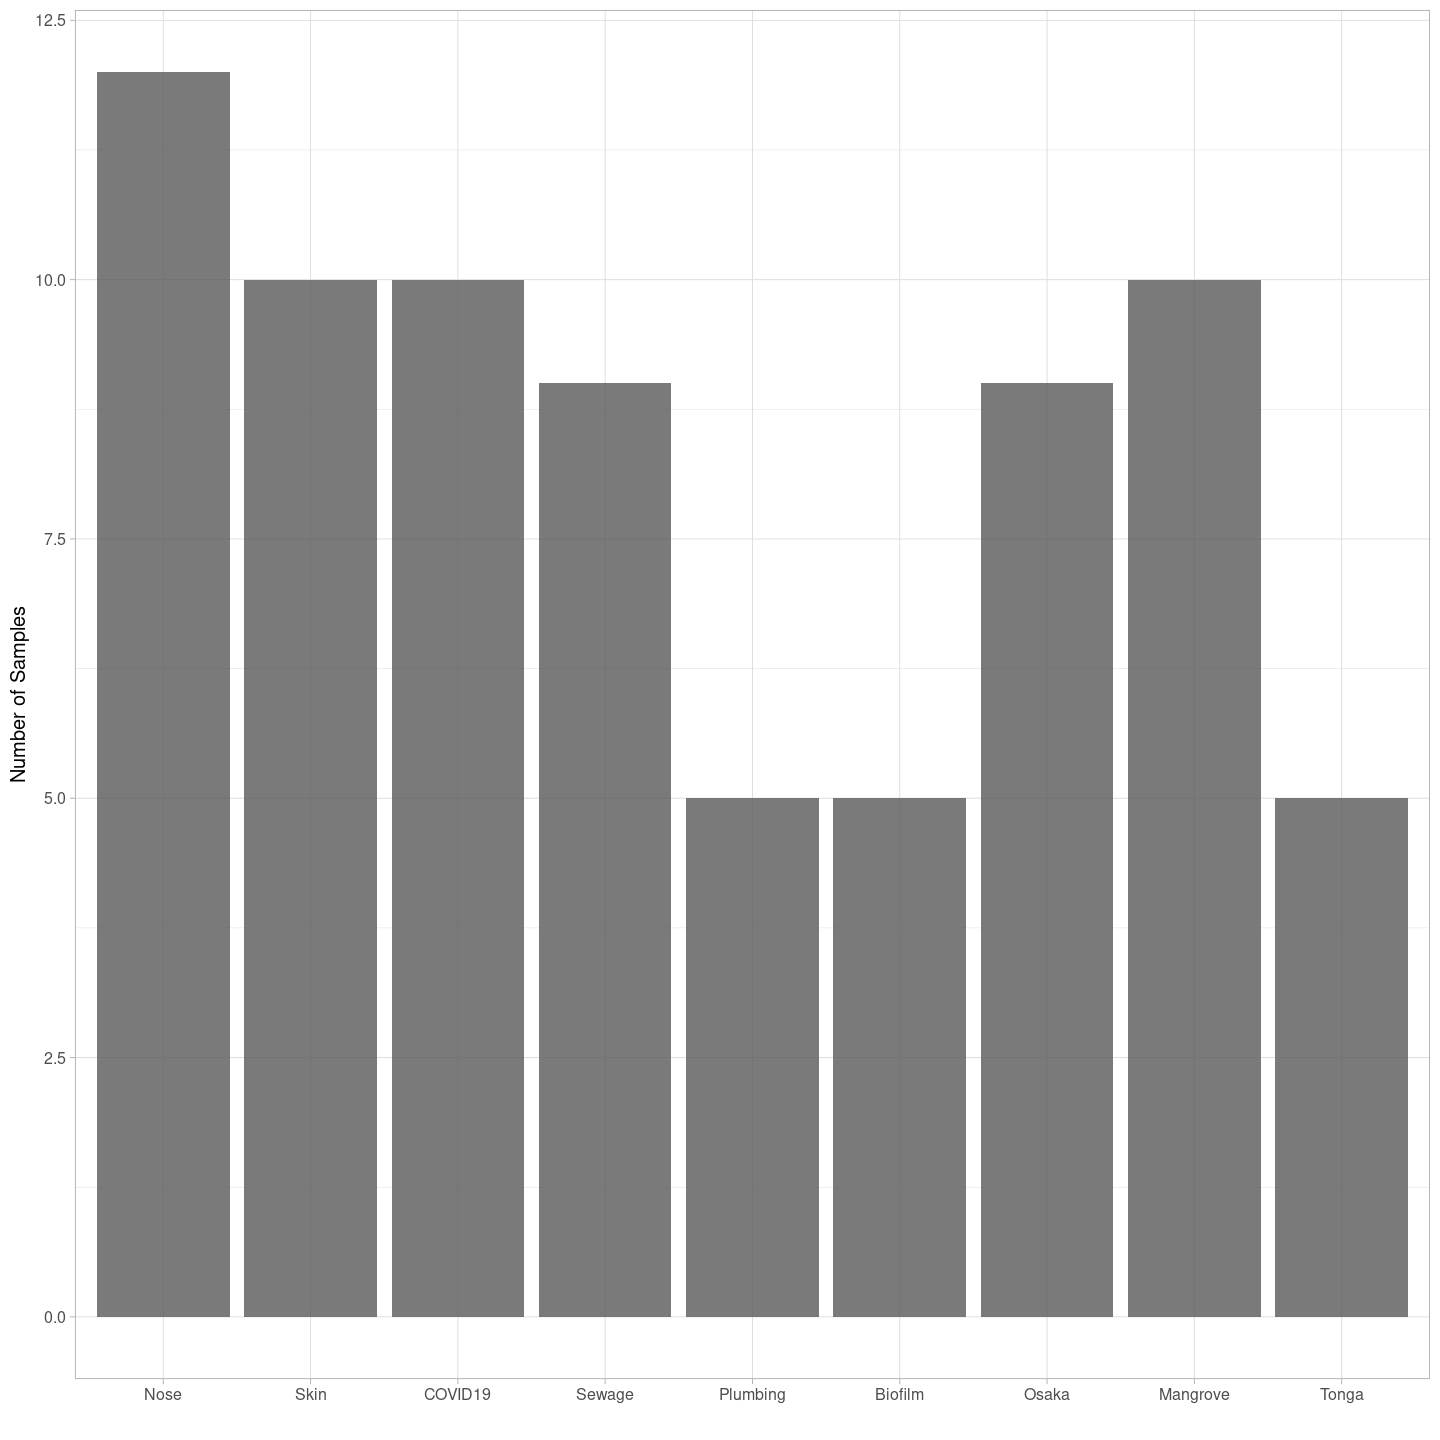

In [12]:
ggplot(samples) +
    geom_bar(aes(x = project), alpha = myalpha) +
    labs (x = "", y = "Number of Samples") +
    theme_light(base_size = 12)
ggsave("figs/metaBGC_samples_per_project.pdf", width = 8, height = 6)

# The distribution of the reads per project:

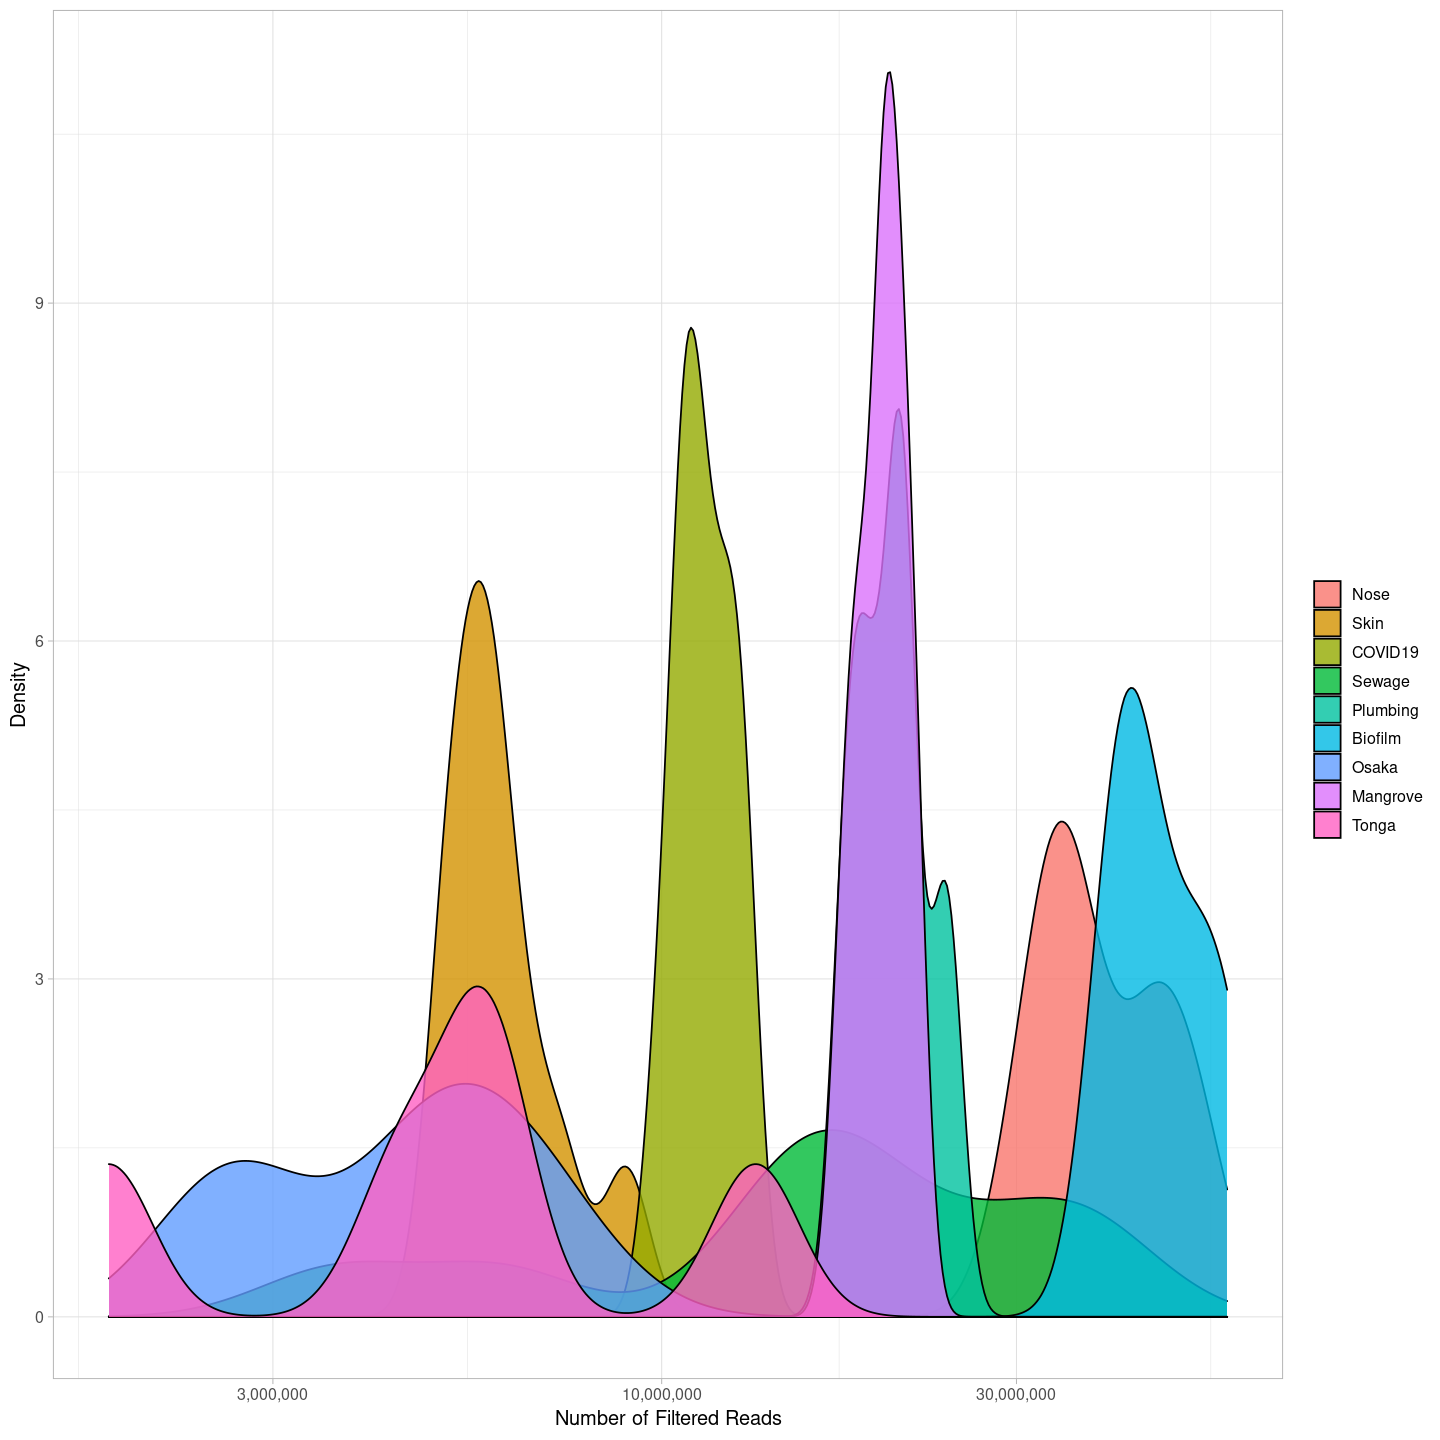

In [13]:
ggplot(reads2) +
    geom_density(aes(x = filtered, fill = project), alpha = myalpha) +
    theme_light(base_size = 12) +
    scale_x_continuous(trans = "log10", labels = scales::comma) +
    labs (x = "Number of Filtered Reads", y = "Density", fill = "") 
ggsave("figs/metaBGC_reads_per_sample.pdf", width = 8, height = 6)

# Contigs size

In [14]:
contigs.sizes = read_tsv("tables/contigs.sizes.tsv.gz") %>% inner_join(projects)
head(contigs.sizes)


── Column specification ────────────────────────────────────────────────────────
cols(
  sample = col_character(),
  contig = col_character(),
  length = col_double()
)


Joining, by = "sample"

inner_join: added 3 columns (accession, project, description)

            > rows only in x  (        0)

            > rows only in y  (       43)

            > matched rows     5,373,454

            >                 ===========

            > rows total       5,373,454



sample    contig   length accession project
1 DRR099940 k79_531  9321   PRJDB6156 Osaka  
2 DRR099940 k79_8175 7486   PRJDB6156 Osaka  
3 DRR099940 k79_6025 7304   PRJDB6156 Osaka  
4 DRR099940 k79_5583 6726   PRJDB6156 Osaka  
5 DRR099940 k79_2115 5147   PRJDB6156 Osaka  
6 DRR099940 k79_1091 5145   PRJDB6156 Osaka  
  description                         
1 Osaka Bay Metatranscriptome (Marine)
2 Osaka Bay Metatranscriptome (Marine)
3 Osaka Bay Metatranscriptome (Marine)
4 Osaka Bay Metatranscriptome (Marine)
5 Osaka Bay Metatranscriptome (Marine)
6 Osaka Bay Metatranscriptome (Marine)

In [15]:
contigs.summary.tsv = contigs.sizes %>% group_by(project, sample) %>% summarise (number = n(), total = sum(length), min = min(length), median = median(length), max = max(length))
head(contigs.summary.tsv)
write_tsv(contigs.summary.tsv, "tables/contigs.summary.tsv")

group_by: 2 grouping variables (project, sample)

summarise: now 75 rows and 7 columns, one group variable remaining (project)



project sample     number total    min median max  
1 Nose    SRR9696273 94964  40266597 200 358    37829
2 Nose    SRR9696274 43565  15860712 247 337    16576
3 Nose    SRR9696275 18676   6889326 247 335     5245
4 Nose    SRR9696276 30113  11037939 247 335    16689
5 Nose    SRR9696277 10537   5324245 247 376    16683
6 Nose    SRR9696278 44869  16467095 241 337     4667

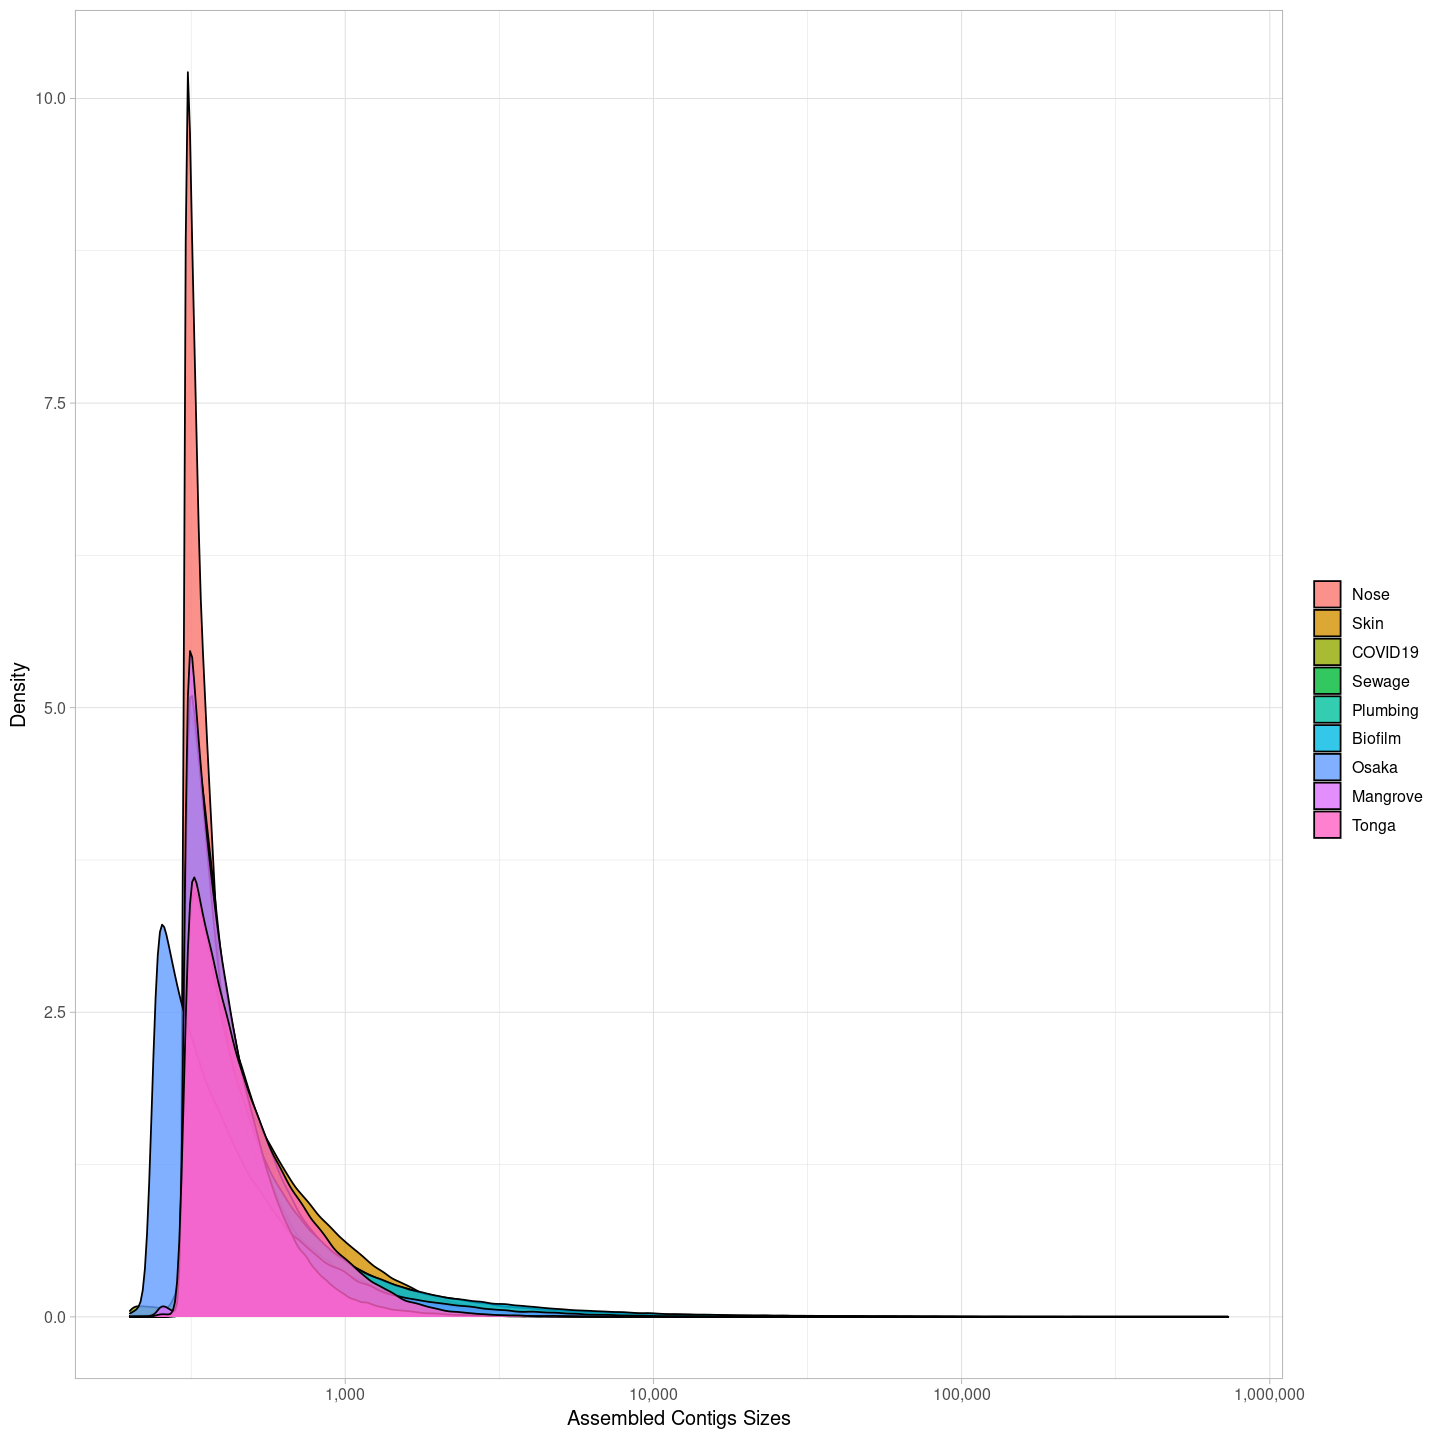

In [16]:
ggplot(contigs.sizes) +
    geom_density(aes(x = length, fill = project), alpha = myalpha) +
    scale_x_continuous(trans = "log10", labels = scales::comma) +
    theme_light(base_size = 12) +
    labs (x = "Assembled Contigs Sizes", y = "Density", fill = "")

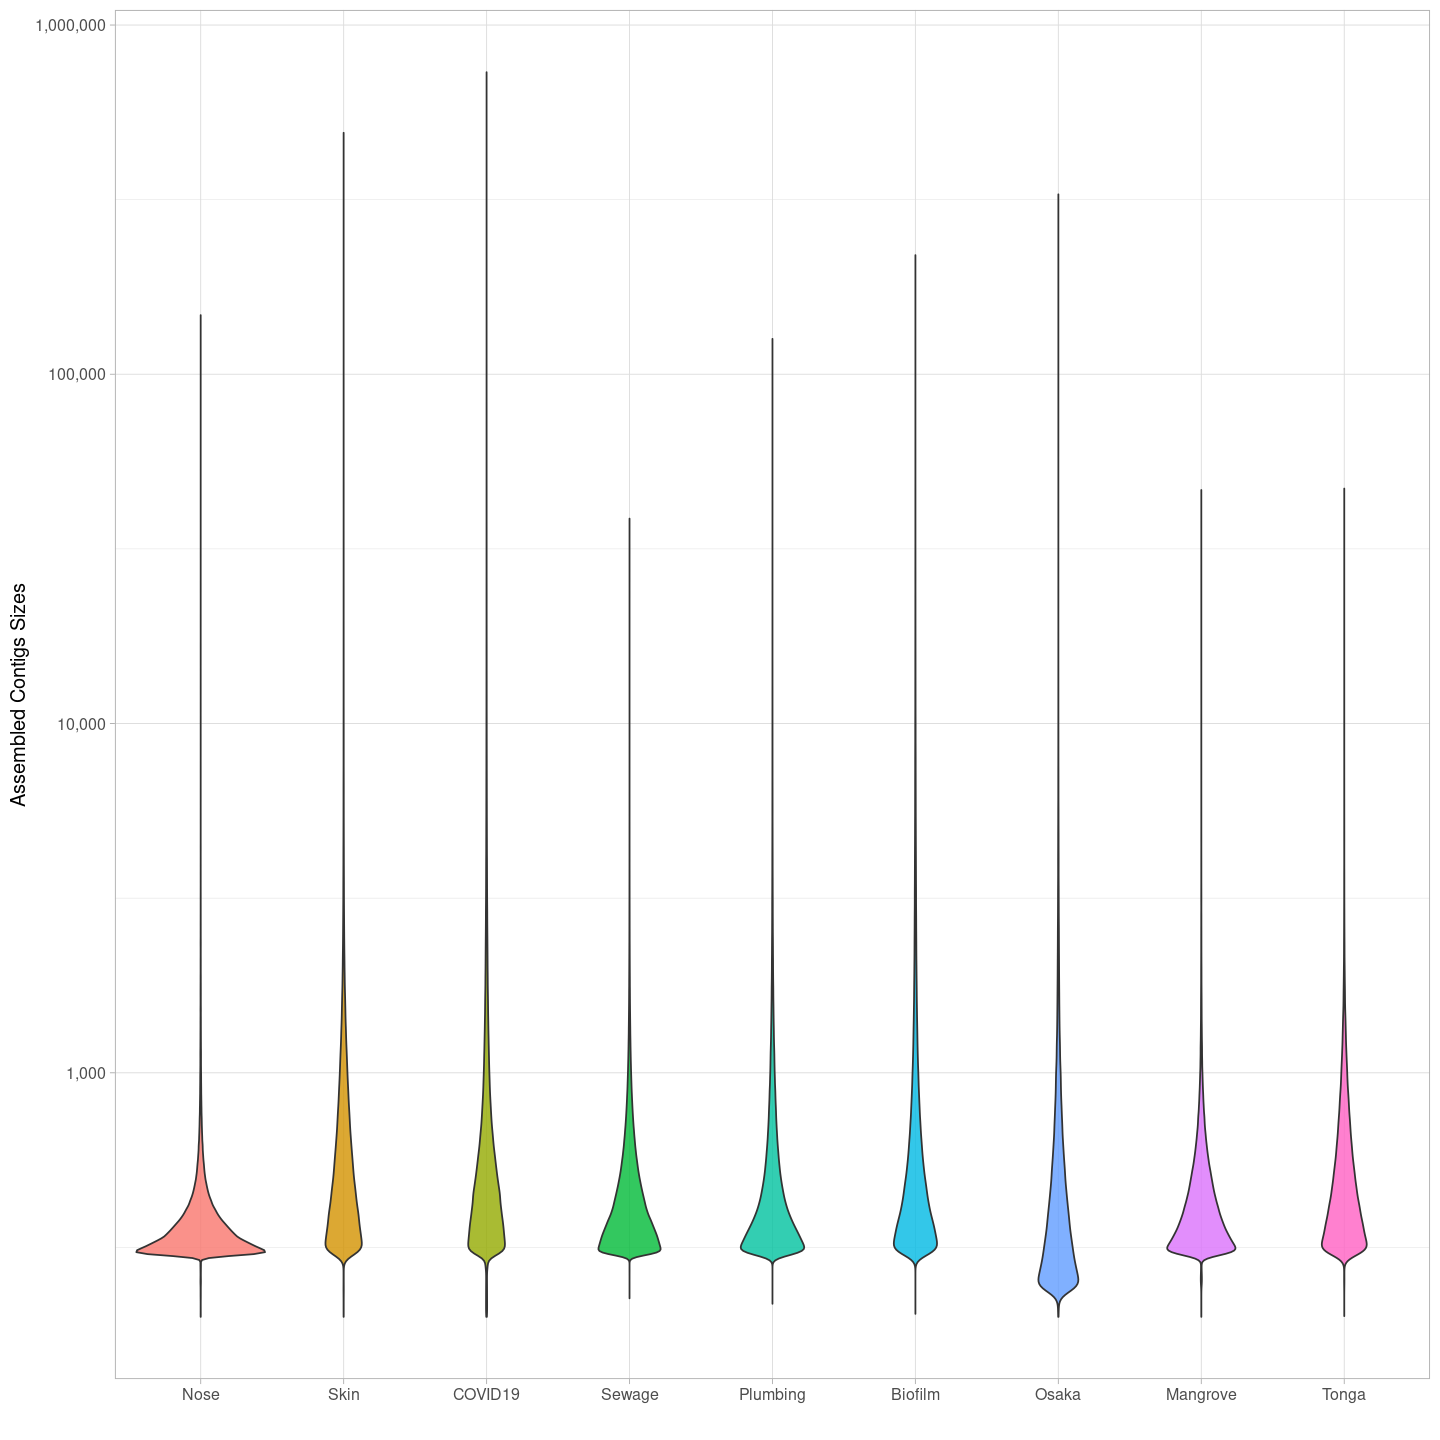

In [17]:
ggplot(contigs.sizes) +
    geom_violin(aes(x = project, y = length, fill = project), alpha = myalpha) +
    scale_y_continuous(trans = "log10", labels = scales::comma) +
    theme_light(base_size = 12) +
    theme(legend.position = "none") +
    labs (x = "", y = "Assembled Contigs Sizes")
ggsave("figs/metaBGC_contigs_sizes.pdf", width = 8, height = 7)

In [18]:
contigs.sizes2 = contigs.sizes %>% group_by(project, sample) %>% summarise(median = median(length), max = max(length)) %>% inner_join(samples) %>% inner_join(reads2)
head(contigs.sizes2)

group_by: 2 grouping variables (project, sample)

summarise: now 75 rows and 4 columns, one group variable remaining (project)

Joining, by = c("project", "sample")

inner_join: added 2 columns (accession, description)

            > rows only in x  ( 0)

            > rows only in y  ( 0)

            > matched rows     75

            >                 ====

            > rows total       75

Joining, by = c("project", "sample", "accession", "description")

inner_join: added one column (filtered)

            > rows only in x  ( 0)

            > rows only in y  ( 0)

            > matched rows     75

            >                 ====

            > rows total       75



project sample     median max   accession   description                 
1 Nose    SRR9696273 358    37829 PRJNA472006 Human Skin Metagenome (Nose)
2 Nose    SRR9696274 337    16576 PRJNA472006 Human Skin Metagenome (Nose)
3 Nose    SRR9696275 335     5245 PRJNA472006 Human Skin Metagenome (Nose)
4 Nose    SRR9696276 335    16689 PRJNA472006 Human Skin Metagenome (Nose)
5 Nose    SRR9696277 376    16683 PRJNA472006 Human Skin Metagenome (Nose)
6 Nose    SRR9696278 337     4667 PRJNA472006 Human Skin Metagenome (Nose)
  filtered
1 31778213
2 53638515
3 35391282
4 35178043
5 34191678
6 50934770

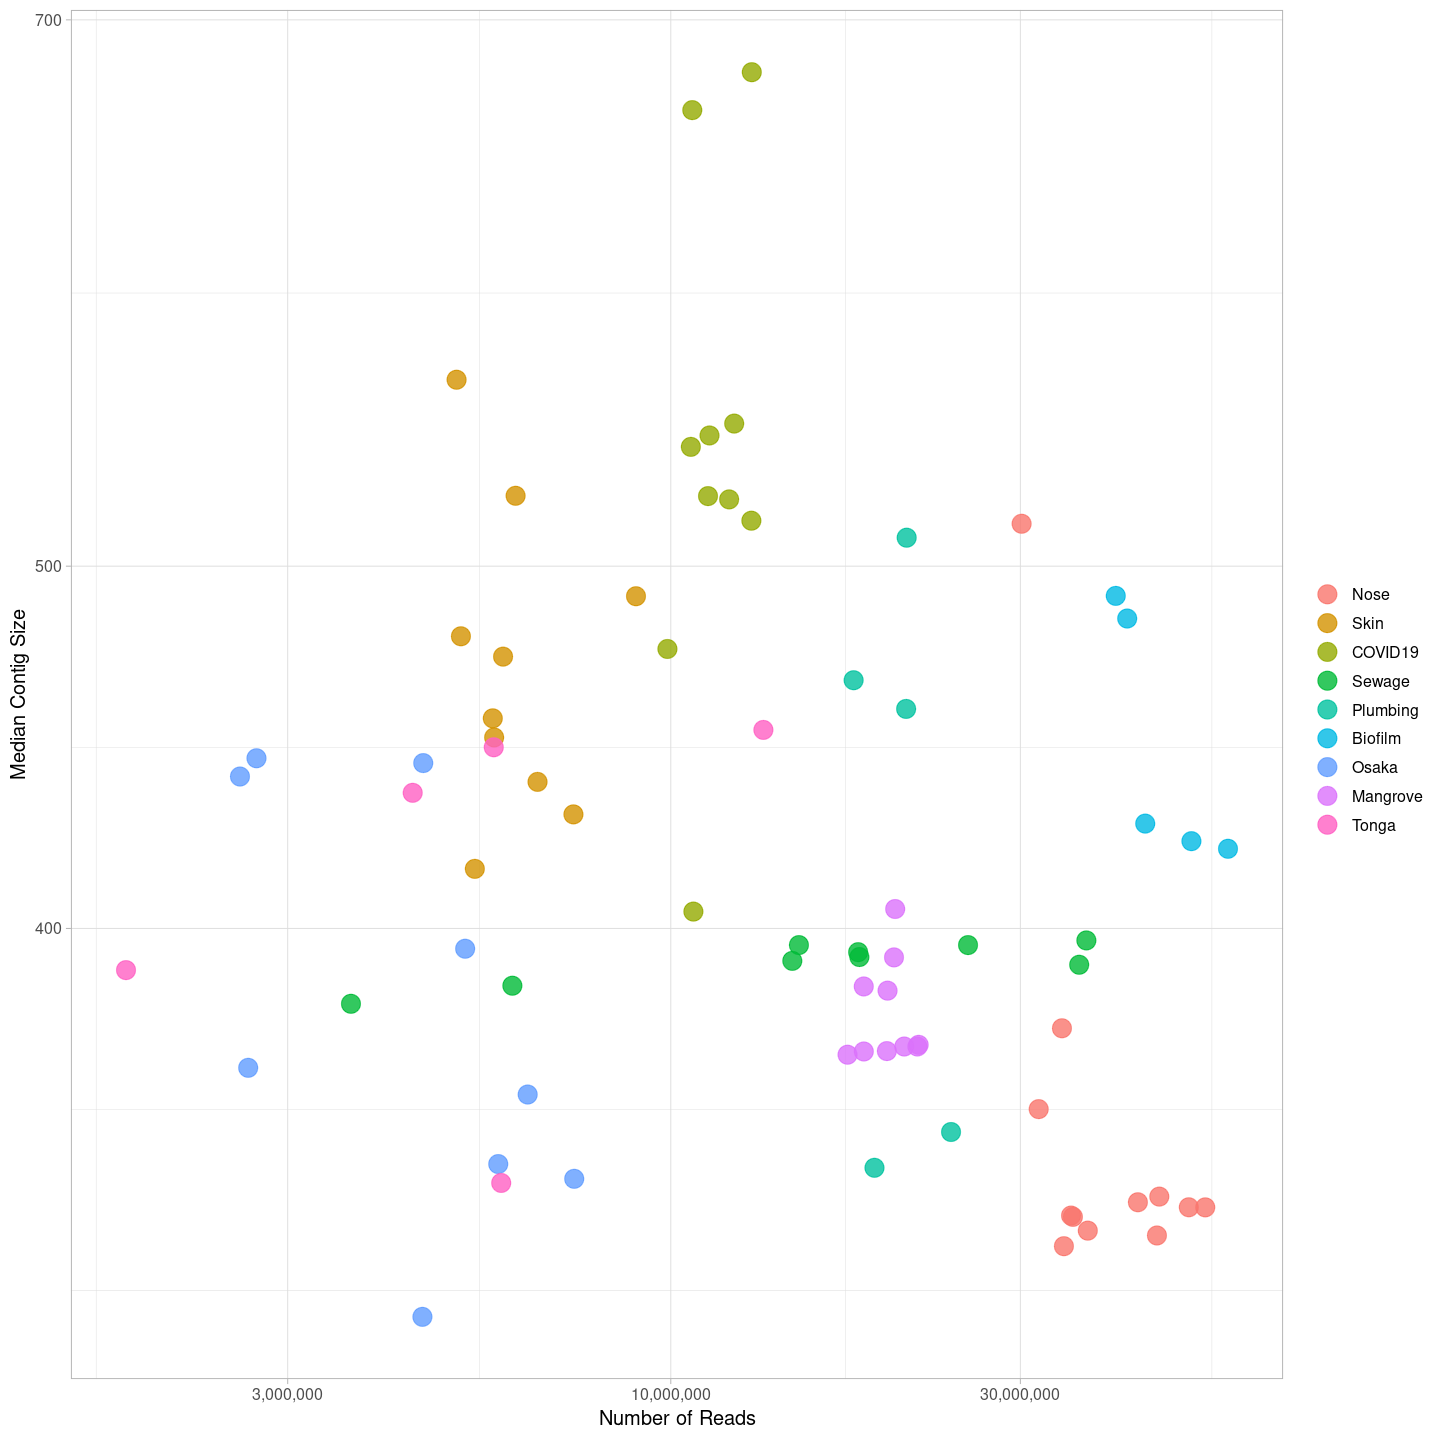

In [19]:
p1 = ggplot(contigs.sizes2) +
    geom_jitter(aes(x = filtered, y = median, color = project), size = 5, alpha = myalpha) +
    scale_x_continuous(trans = "log10", labels = scales::comma) +
    scale_y_continuous(trans = "log10", labels = scales::comma) +
    theme_light(base_size = 12) +
    labs (x = "Number of Reads", y = "Median Contig Size", color = "")
p1

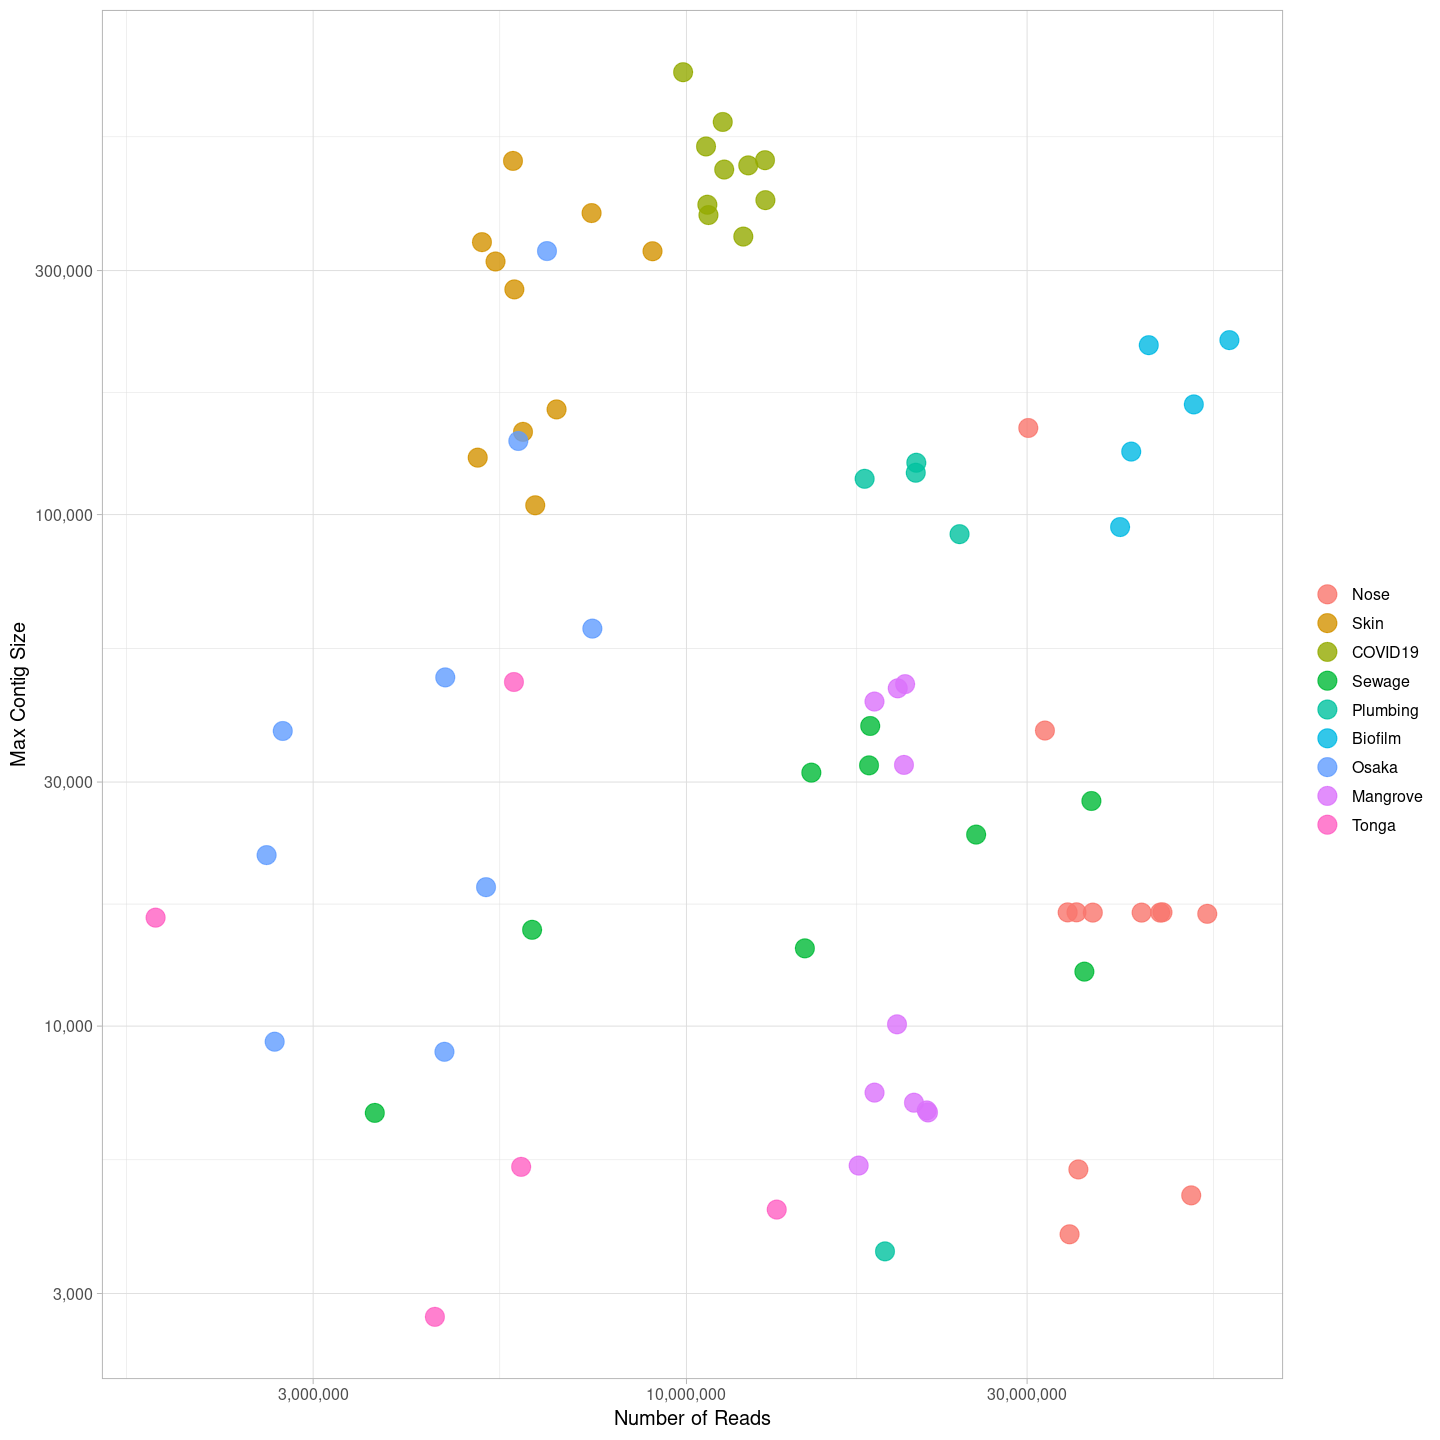

In [20]:
p2 = ggplot(contigs.sizes2) +
    geom_jitter(aes(x = filtered, y = max, color = project), size = 5, alpha = myalpha) +
    scale_x_continuous(trans = "log10", labels = scales::comma) +
    scale_y_continuous(trans = "log10", labels = scales::comma) +
    theme_light(base_size = 12) +
    labs (x = "Number of Reads", y = "Max Contig Size", color = "")
p2

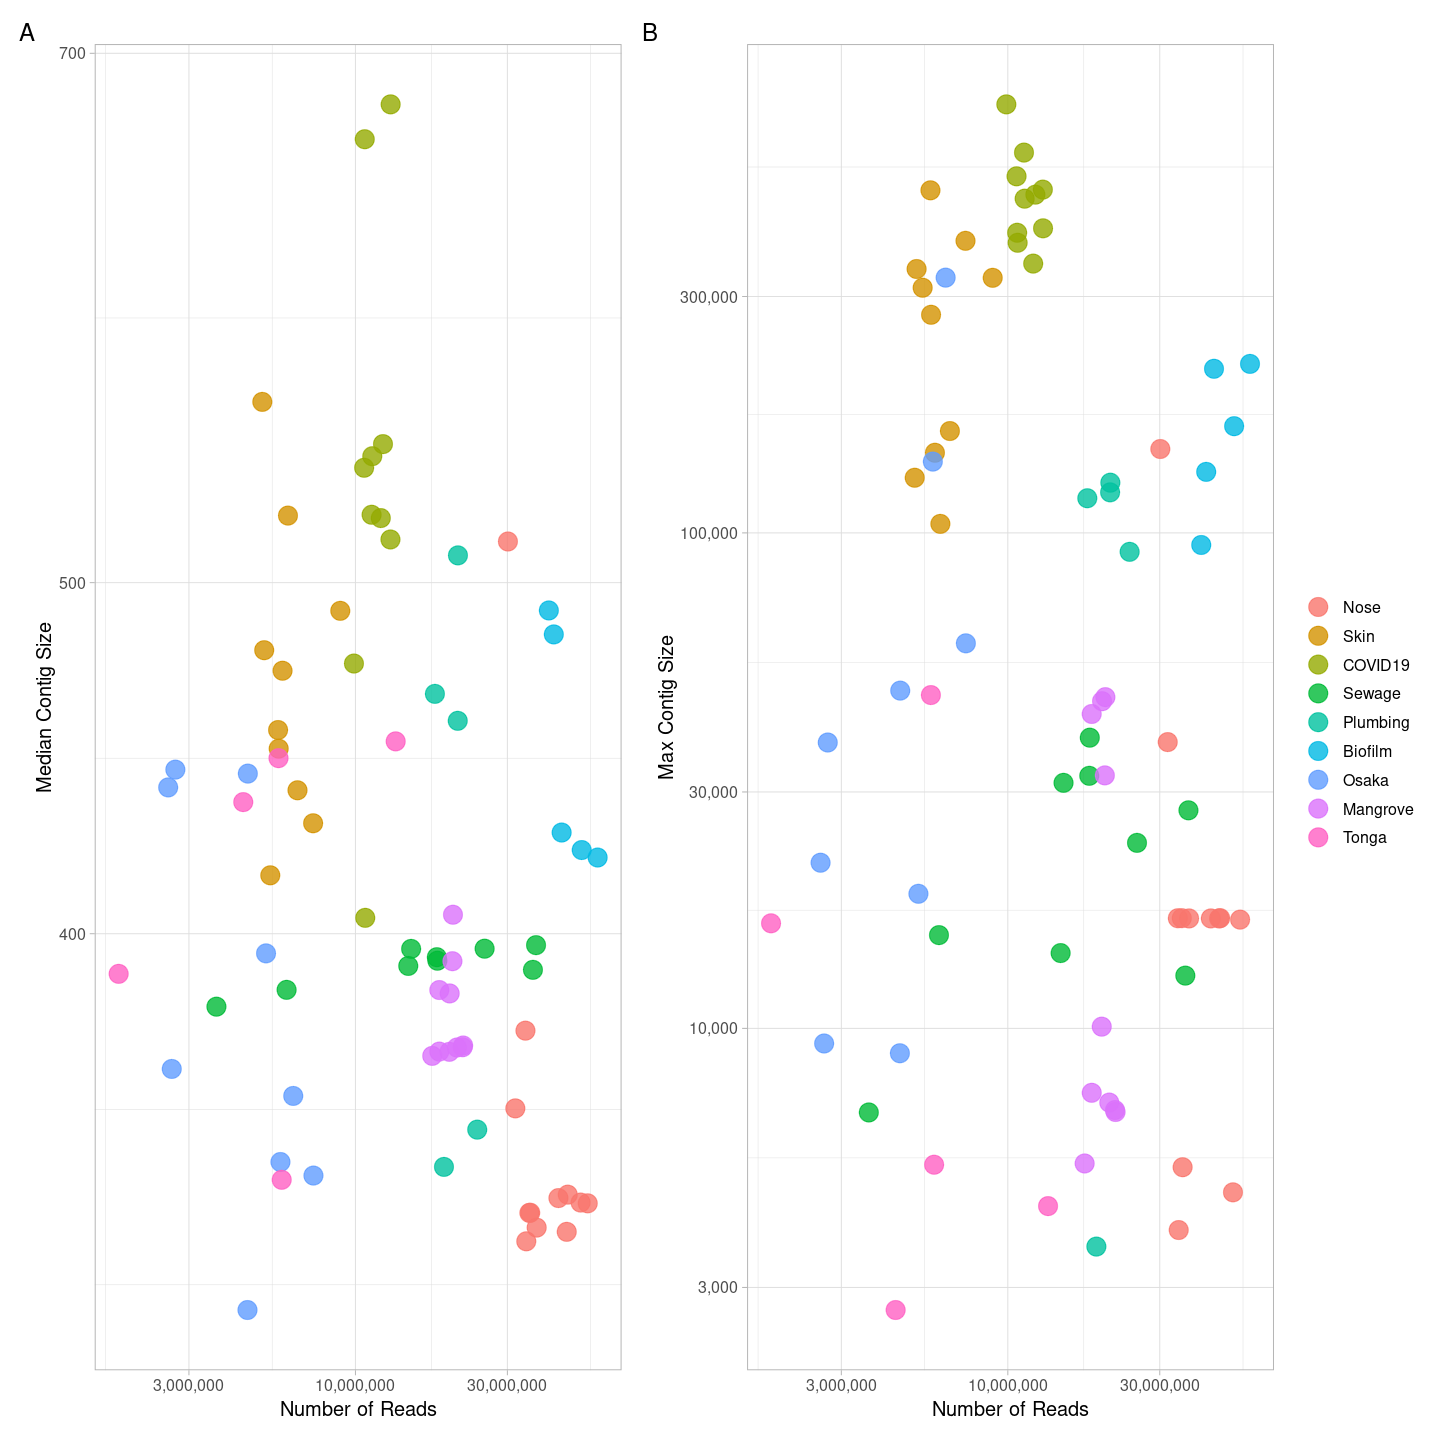

In [21]:
(p1 + theme(legend.position = "none") )+ p2 + plot_annotation(tag_levels = 'A')
ggsave("figs/metaBGC_contigs_vs_reads.pdf", width = 14, height = 8)

# Taxonomic distribution by project (Genus-level)

In [22]:
# Loading taxonomic classification
t1 = read_tsv("tables/reads.taxonomy.tsv") %>% filter(taxonomy_lvl == "G")
t2 = samples %>% inner_join(t1) %>% mutate (abundance = as.double(fraction_total_reads))
head(t2)


── Column specification ────────────────────────────────────────────────────────
cols(
  sample = col_character(),
  name = col_character(),
  taxonomy_id = col_double(),
  taxonomy_lvl = col_character(),
  kraken_assigned_reads = col_double(),
  added_reads = col_double(),
  new_est_reads = col_double(),
  fraction_total_reads = col_double()
)


filter: removed 415,708 rows (80%), 104,921 rows remaining

Joining, by = "sample"

inner_join: added 7 columns (name, taxonomy_id, taxonomy_lvl, kraken_assigned_reads, added_reads, …)

            > rows only in x  (      0)

            > rows only in y  (      0)

            > matched rows     104,921    (includes duplicates)

            >                 =========

            > rows total       104,921

mutate: new variable 'abundance' (double) with 1,502 unique values and 0% NA



sample    accession project description                         
1 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
2 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
3 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
4 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
5 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
6 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
  name                            taxonomy_id taxonomy_lvl
1 Candidatus Prometheoarchaeum    2732160     G           
2 Candidatus Pelagibacter          198251     G           
3 Candidatus Nitrosomarinus       1993653     G           
4 Candidatus Phytoplasma            33926     G           
5 Candidatus Methanomethylophilus 1291539     G           
6 Candidatus Nitrosopelagicus     1593364     G           
  kraken_assigned_reads added_reads new_est_reads fraction_total_reads
1   182                 110332      110514        0.10700             
2 40969                   8555       49524        0.04795             
3 25598                   7872       33470        0.03240             
4  2736                    121        2857        0.00277             
5    24                   2713        2737        0.00265             
6  1870                     59        1929        0.00187             
  abundance
1 0.10700  
2 0.04795  
3 0.03240  
4 0.00277  
5 0.00265  
6 0.00187

## Human Reads Abundance

In [23]:
human = t2 %>% filter(name %in% human_taxa) %>% rename (human = abundance) %>% select (project, sample, human) %>% arrange(desc(human))
head(human)

filter: removed 104,846 rows (>99%), 75 rows remaining

rename: renamed one variable (human)

select: dropped 9 variables (accession, description, name, taxonomy_id, taxonomy_lvl, …)



project sample     human  
1 Nose    SRR9696274 0.99877
2 Nose    SRR9696280 0.99801
3 Nose    SRR9696276 0.99794
4 Nose    SRR9696275 0.99649
5 Nose    SRR9696278 0.99540
6 Nose    SRR9696284 0.99516

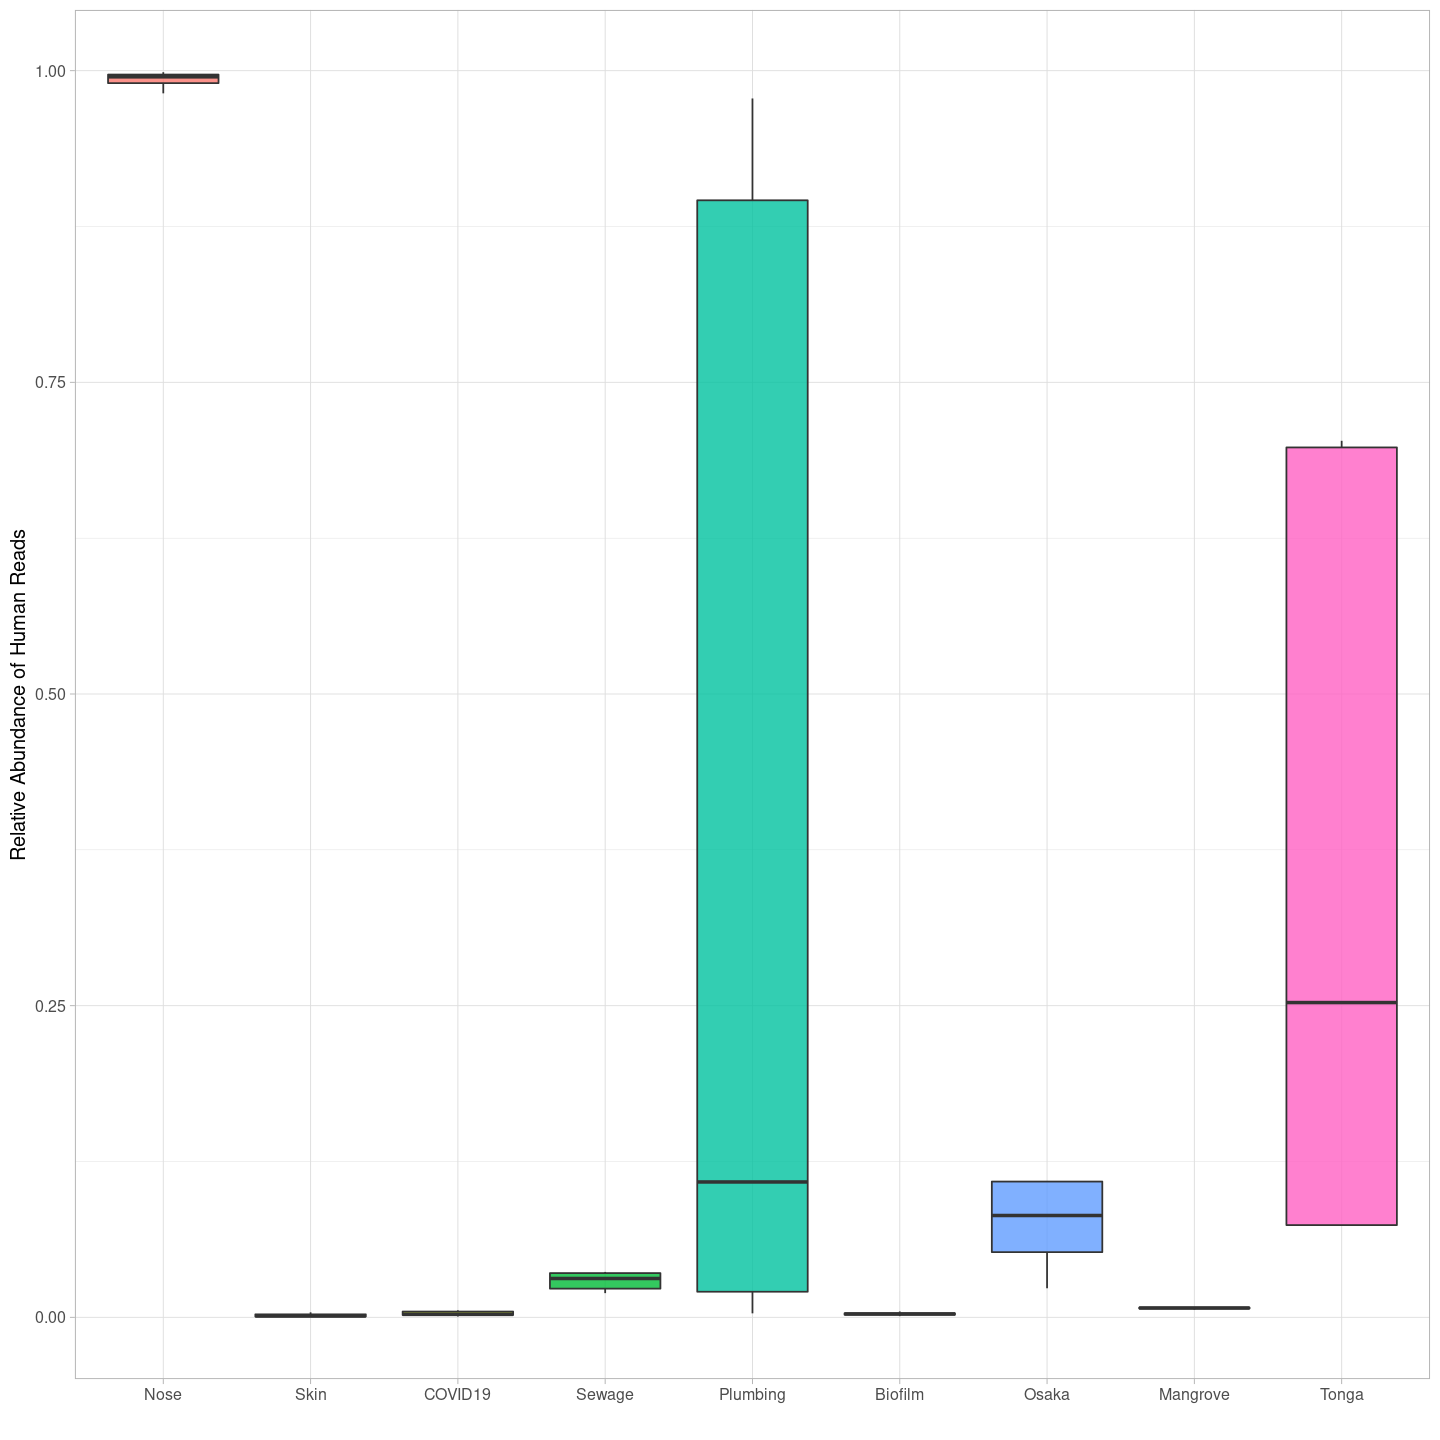

In [24]:
ggplot(human) +
    geom_boxplot(aes (x = project, y = human, fill = project), alpha = myalpha, outlier.shape = NA) +
    theme_light(base_size = 12) +
    labs (x = "", y = "Relative Abundance of Human Reads", fill = "") +
    theme(legend.position = "none")
ggsave("figs/metaBGC_human_reads_abundance.pdf", width = 10, height = 6)

In [25]:
# t3 = t2 %>% filter(!(name %in% human)) %>% arrange(desc(abundance))
# t3 = t2 %>% arrange(desc(abundance))
t3 = t2 %>% left_join(human) %>% mutate (abundance = ifelse(is.na(human), abundance, abundance / (1-human))) %>% select(-human) %>% filter(!(name %in% human_taxa))
head(t3)

Joining, by = c("sample", "project")

left_join: added one column (human)

           > rows only in x         0

           > rows only in y  (      0)

           > matched rows     104,921

           >                 =========

           > rows total       104,921

mutate: changed 67,005 values (64%) of 'abundance' (0 new NA)

select: dropped one variable (human)

filter: removed 75 rows (<1%), 104,846 rows remaining



sample    accession project description                         
1 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
2 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
3 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
4 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
5 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
6 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
  name                            taxonomy_id taxonomy_lvl
1 Candidatus Prometheoarchaeum    2732160     G           
2 Candidatus Pelagibacter          198251     G           
3 Candidatus Nitrosomarinus       1993653     G           
4 Candidatus Phytoplasma            33926     G           
5 Candidatus Methanomethylophilus 1291539     G           
6 Candidatus Nitrosopelagicus     1593364     G           
  kraken_assigned_reads added_reads new_est_reads fraction_total_reads
1   182                 110332      110514        0.10700             
2 40969                   8555       49524        0.04795             
3 25598                   7872       33470        0.03240             
4  2736                    121        2857        0.00277             
5    24                   2713        2737        0.00265             
6  1870                     59        1929        0.00187             
  abundance  
1 0.120079005
2 0.053811106
3 0.036360372
4 0.003108587
5 0.002973919
6 0.002098577

In [26]:
top_taxa_cutoff = 10
top_taxa = t3 %>% group_by(sample) %>% arrange(desc(abundance)) %>% filter(row_number() <= top_taxa_cutoff) %>% ungroup() %>% select(name) %>% distinct()
head(top_taxa)

group_by: one grouping variable (sample)

filter (grouped): removed 104,096 rows (99%), 750 rows remaining

ungroup: no grouping variables

select: dropped 11 variables (sample, accession, project, description, taxonomy_id, …)

distinct: removed 617 rows (82%), 133 rows remaining



name                  
1 Bacteroides           
2 Cutibacterium         
3 Staphylococcus        
4 Corynebacterium       
5 Erysipelatoclostridium
6 Acinetobacter

In [27]:
nrow(top_taxa)

[1] 133

In [28]:
# The maximum abundance for each taxa across all samples
max = t3 %>% group_by(taxonomy_id, name) %>% summarise(max = max(abundance)) %>% arrange(desc(max))
head(max)

group_by: 2 grouping variables (taxonomy_id, name)

summarise: now 2,408 rows and 3 columns, one group variable remaining (taxonomy_id)



taxonomy_id name                   max      
1     816     Bacteroides            0.9787949
2 1912216     Cutibacterium          0.8786429
3    1279     Staphylococcus         0.7516492
4    1716     Corynebacterium        0.6973032
5 1505663     Erysipelatoclostridium 0.6052875
6     469     Acinetobacter          0.5764423

In [29]:
# Determine the major taxa and exclude human (based on genus or species)
major = max %>% filter(max > abundance_cutoff)
head(major)
nrow(major)

filter (grouped): removed 2,283 rows (95%), 125 rows remaining



taxonomy_id name                   max      
1     816     Bacteroides            0.9787949
2 1912216     Cutibacterium          0.8786429
3    1279     Staphylococcus         0.7516492
4    1716     Corynebacterium        0.6973032
5 1505663     Erysipelatoclostridium 0.6052875
6     469     Acinetobacter          0.5764423

[1] 125

In [30]:
# Mark the non-major taxa as _other_ and group them together per sample
t4 = t3 %>%
  mutate(name = ifelse(name %in% major$name, name, "_other_")) %>%
  group_by(project, sample, name) %>%
  summarise(abundance = sum(abundance))
head(t4)

mutate: changed 96,279 values (92%) of 'name' (0 new NA)

group_by: 3 grouping variables (project, sample, name)

summarise: now 8,642 rows and 4 columns, 2 group variables remaining (project, sample)



project sample     name          abundance   
1 Nose    SRR9696273 _other_       0.0264171712
2 Nose    SRR9696273 Achromobacter 0.0000000000
3 Nose    SRR9696273 Acidovorax    0.0005503577
4 Nose    SRR9696273 Acinetobacter 0.0011007155
5 Nose    SRR9696273 Aeromonas     0.0005503577
6 Nose    SRR9696273 Agrobacterium 0.0000000000

In [31]:
t4 = t3 %>% inner_join(top_taxa)
head(t4)

Joining, by = "name"

inner_join: added no columns

            > rows only in x  (95,673)

            > rows only in y  (     0)

            > matched rows      9,173

            >                 ========

            > rows total        9,173



sample    accession project description                         
1 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
2 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
3 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
4 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
5 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
6 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
  name                         taxonomy_id taxonomy_lvl kraken_assigned_reads
1 Candidatus Prometheoarchaeum 2732160     G               182               
2 Candidatus Pelagibacter       198251     G             40969               
3 Candidatus Nitrosomarinus    1993653     G             25598               
4 Candidatus Mancarchaeum      2490204     G                10               
5 Bacillus                        1386     G             65545               
6 Halomonas                       2745     G            156080               
  added_reads new_est_reads fraction_total_reads abundance   
1 110332      110514        0.10700              1.200790e-01
2   8555       49524        0.04795              5.381111e-02
3   7872       33470        0.03240              3.636037e-02
4      0          10        0.00001              1.122234e-05
5 119636      185181        0.17929              2.012053e-01
6  17257      173337        0.16782              1.883333e-01

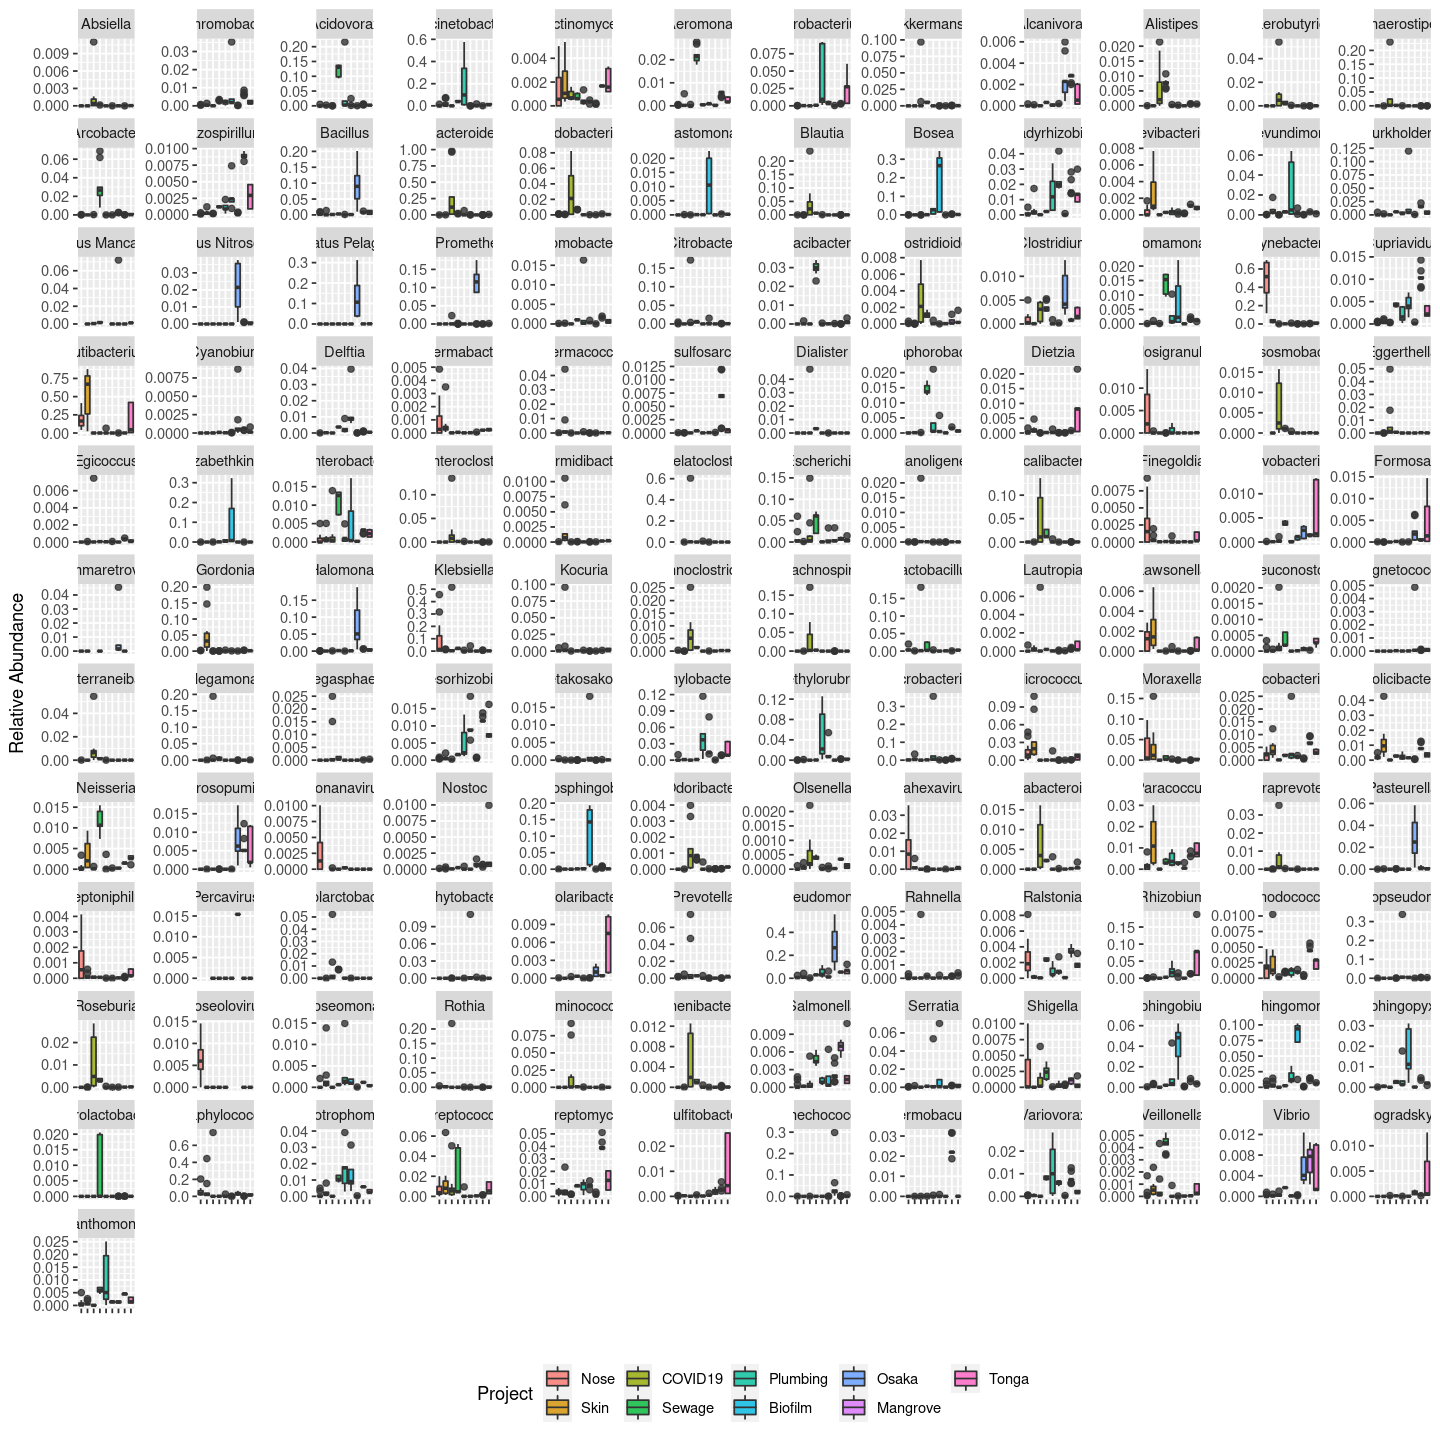

In [32]:
# Boxplot of the abundances
ggplot(t4) +
    geom_boxplot(aes(x = project, y = abundance, fill = project), alpha = myalpha) +
    theme(legend.position = "bottom") +
    labs (x = "", y = "Relative Abundance", fill = "Project") +
    theme(axis.text.x = element_blank()) +
    facet_wrap (~name, scales = "free_y")

In [33]:
ggsave("figs/metaBGC_taxa_abundance_boxplot.pdf", width = 30, height = 20, limitsize = FALSE)

In [34]:
dominant = t4 %>% group_by(sample) %>% arrange(desc(abundance)) %>% filter (row_number() == 1) %>% select(sample, name, abundance)
head(dominant)

group_by: one grouping variable (sample)

filter (grouped): removed 9,098 rows (99%), 75 rows remaining

select: dropped 9 variables (accession, project, description, taxonomy_id, taxonomy_lvl, …)



sample      name          abundance
1 SRR12328948 Bacteroides   0.9787949
2 SRR12328943 Bacteroides   0.9619048
3 SRR7802475  Cutibacterium 0.8786429
4 SRR7802476  Cutibacterium 0.8702271
5 SRR7802339  Cutibacterium 0.7858015
6 SRR7802349  Cutibacterium 0.7805066

In [35]:
# Calculate the medians of taxa abundances per project
medians = t4 %>% group_by(project, name) %>% summarise(abundance = median(abundance)) %>% arrange (project, desc(abundance))
head(medians)

group_by: 2 grouping variables (project, name)

summarise: now 1,184 rows and 3 columns, one group variable remaining (project)



project name            abundance  
1 Nose    Corynebacterium 0.515912723
2 Nose    Cutibacterium   0.164385584
3 Nose    Staphylococcus  0.032816366
4 Nose    Klebsiella      0.013825816
5 Nose    Micrococcus     0.008621330
6 Nose    Pahexavirus     0.008405736

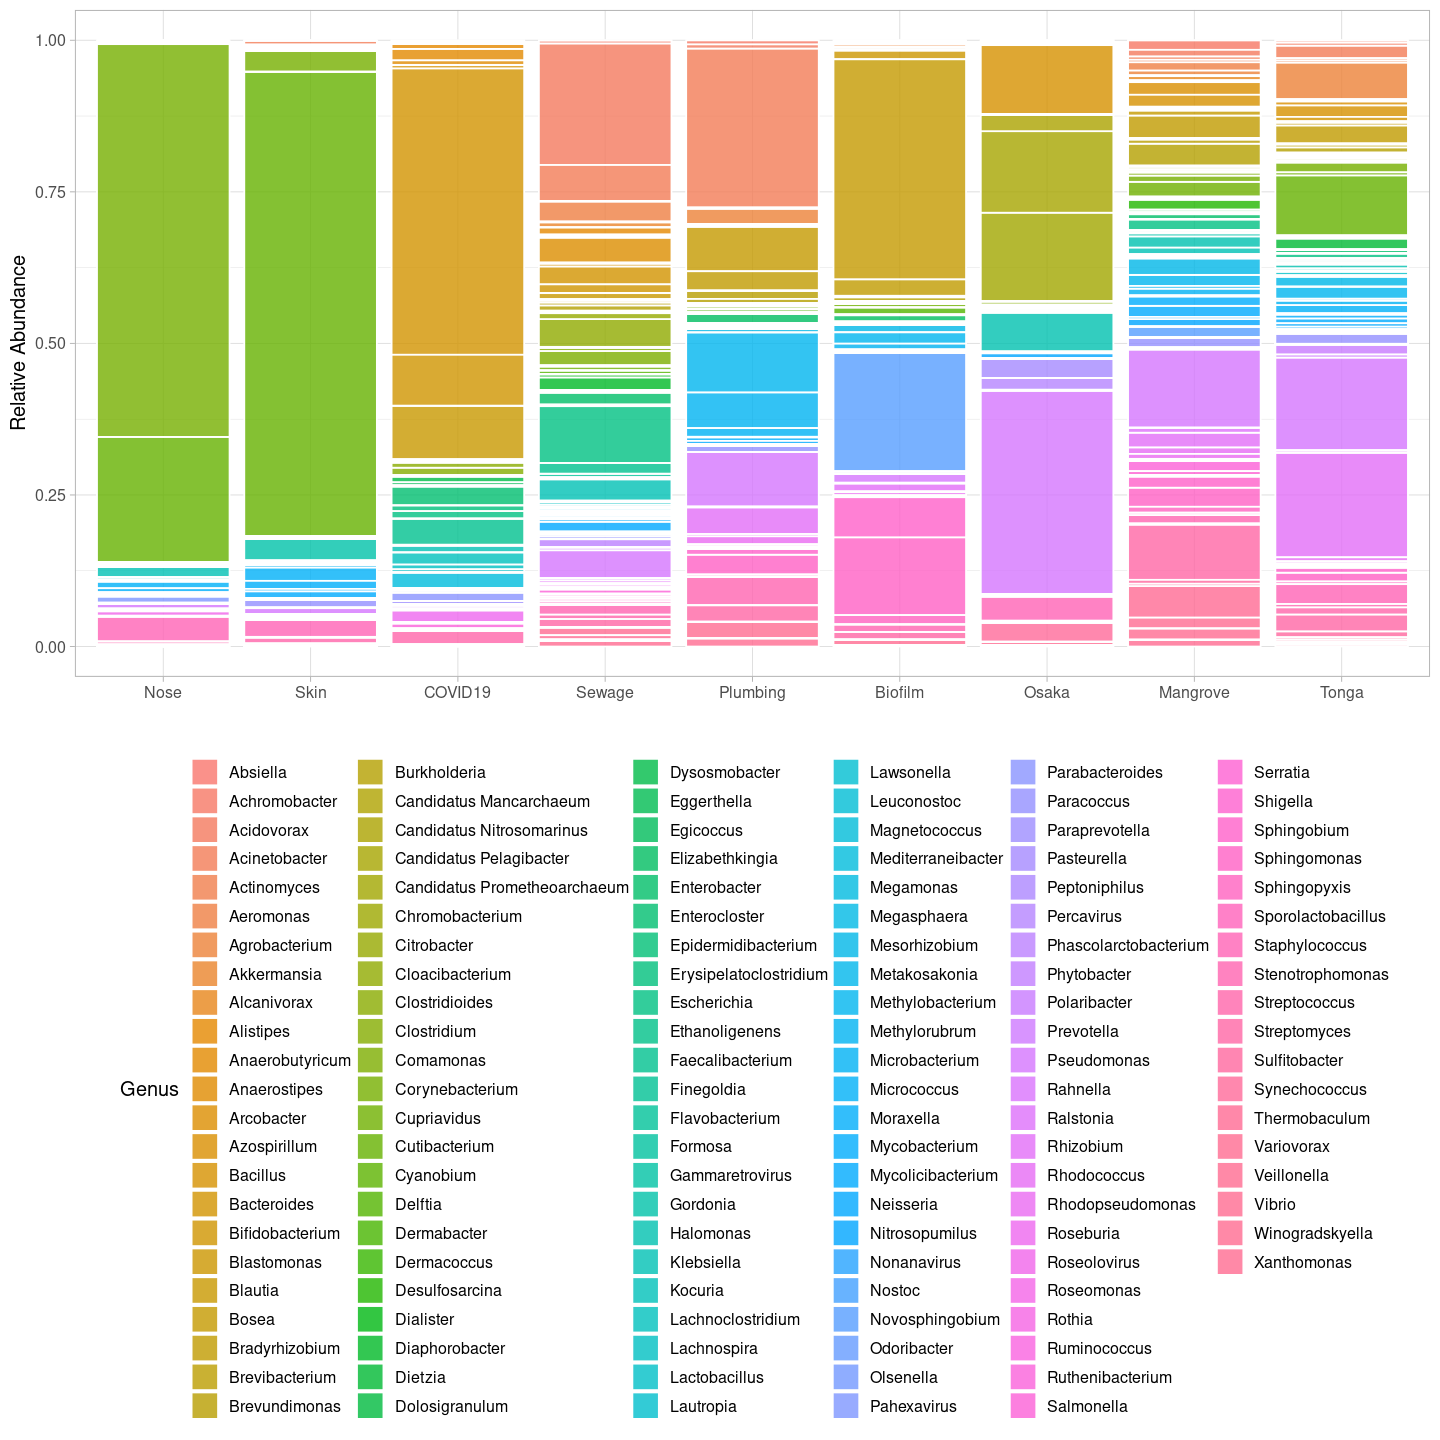

In [36]:
# Bar plot of the medians
ggplot(medians) +
    geom_bar(aes(x = project, y = abundance, fill = name), color = "white", stat = "identity", alpha = myalpha, position = "fill") +
    theme_light(base_size = 12) +
    theme(legend.position = "bottom") +
    guides(fill = guide_legend(ncol = 6)) + 
    labs (x = "", y = "Relative Abundance", fill = "Genus")
ggsave("figs/metaBGC_taxa_abundance_barplot.pdf", width = 12, height = 10)

In [37]:
head(medians)

project name            abundance  
1 Nose    Corynebacterium 0.515912723
2 Nose    Cutibacterium   0.164385584
3 Nose    Staphylococcus  0.032816366
4 Nose    Klebsiella      0.013825816
5 Nose    Micrococcus     0.008621330
6 Nose    Pahexavirus     0.008405736

In [38]:
medians2 = medians %>% top_n(1, wt = abundance)
medians2

top_n (grouped): removed 1,175 rows (99%), 9 rows remaining



project  name            abundance 
1 Nose     Corynebacterium 0.51591272
2 Skin     Cutibacterium   0.67168490
3 COVID19  Bacteroides     0.11905749
4 Sewage   Acidovorax      0.13067443
5 Plumbing Acinetobacter   0.09823435
6 Biofilm  Bosea           0.26507680
7 Osaka    Pseudomonas     0.26562710
8 Mangrove Pseudomonas     0.05424603
9 Tonga    Rhizobium       0.07825425

# Taxa PCA (Principal Component Analysis)

In [39]:
m1 = t4 %>% dcast(sample ~ name, value.var = "abundance", fill = 0)
head(m1)

sample    Absiella     Achromobacter Acidovorax   Acinetobacter Actinomyces 
1 DRR099940 0.000000e+00 2.244467e-05  7.855636e-05 0.017720070   2.244467e-05
2 DRR099941 4.095381e-05 3.173921e-04  4.300151e-04 0.002088645   2.252460e-04
3 DRR099942 0.000000e+00 6.551077e-05  1.528585e-04 0.010940298   3.275538e-05
4 DRR099943 6.174110e-05 1.852233e-04  2.366742e-04 0.002407903   1.337724e-04
5 DRR099944 1.055186e-05 3.165559e-05  5.275931e-05 0.001002427   1.055186e-05
6 DRR099945 3.266871e-05 3.266871e-05  1.524540e-04 0.001067178   2.177914e-05
  Aeromonas    Agrobacterium Akkermansia  Alcanivorax  ⋯ Streptococcus
1 0.0002020021 1.234457e-04  5.611168e-05 0.0051510527 ⋯ 0.0004376711 
2 0.0006654995 4.504920e-04  1.023845e-04 0.0010852761 ⋯ 0.0007269302 
3 0.0004039831 1.856138e-04  2.183692e-05 0.0018124645 ⋯ 0.0004913307 
4 0.0004939288 4.630582e-04  5.145092e-05 0.0004424779 ⋯ 0.0011319201 
5 0.0001160705 6.331117e-05  1.055186e-05 0.0022897541 ⋯ 0.0002004854 
6 0.0001960122 9.800612e-05  2.177914e-05 0.0059892629 ⋯ 0.0004682515 
  Streptomyces Sulfitobacter Synechococcus Thermobaculum Variovorax  
1 0.0003591148 0.0018516856  0.01874130    0.000000e+00  8.977870e-05
2 0.0034094050 0.0037882278  0.29870688    1.023845e-05  3.788228e-04
3 0.0005131677 0.0020417522  0.02635716    1.091846e-05  9.826615e-05
4 0.0017596213 0.0035706936  0.06383001    1.029018e-05  2.366742e-04
5 0.0002954521 0.0005064894  0.00277514    0.000000e+00  4.220745e-05
6 0.0001960122 0.0010780673  0.01773911    0.000000e+00  4.355828e-05
  Veillonella  Vibrio      Winogradskyella Xanthomonas 
1 1.122234e-05 0.004073708 0.0004937828    0.0006845626
2 5.119227e-05 0.007596933 0.0010340838    0.0010238454
3 2.183692e-05 0.005120758 0.0006878630    0.0010809276
4 9.261165e-05 0.012399671 0.0013377238    0.0011525005
5 1.055186e-05 0.003060040 0.0002532447    0.0016566424
6 4.355828e-05 0.003190644 0.0011216256    0.0018403371

In [40]:
m2 = m1[, -1]
row.names(m2) = m1$sample
head(m2)

Absiella     Achromobacter Acidovorax   Acinetobacter Actinomyces 
DRR099940 0.000000e+00 2.244467e-05  7.855636e-05 0.017720070   2.244467e-05
DRR099941 4.095381e-05 3.173921e-04  4.300151e-04 0.002088645   2.252460e-04
DRR099942 0.000000e+00 6.551077e-05  1.528585e-04 0.010940298   3.275538e-05
DRR099943 6.174110e-05 1.852233e-04  2.366742e-04 0.002407903   1.337724e-04
DRR099944 1.055186e-05 3.165559e-05  5.275931e-05 0.001002427   1.055186e-05
DRR099945 3.266871e-05 3.266871e-05  1.524540e-04 0.001067178   2.177914e-05
          Aeromonas    Agrobacterium Akkermansia  Alcanivorax  Alistipes    ⋯
DRR099940 0.0002020021 1.234457e-04  5.611168e-05 0.0051510527 3.366701e-05 ⋯
DRR099941 0.0006654995 4.504920e-04  1.023845e-04 0.0010852761 9.214608e-05 ⋯
DRR099942 0.0004039831 1.856138e-04  2.183692e-05 0.0018124645 5.459230e-05 ⋯
DRR099943 0.0004939288 4.630582e-04  5.145092e-05 0.0004424779 6.174110e-05 ⋯
DRR099944 0.0001160705 6.331117e-05  1.055186e-05 0.0022897541 1.055186e-05 ⋯
DRR099945 0.0001960122 9.800612e-05  2.177914e-05 0.0059892629 3.266871e-05 ⋯
          Streptococcus Streptomyces Sulfitobacter Synechococcus Thermobaculum
DRR099940 0.0004376711  0.0003591148 0.0018516856  0.01874130    0.000000e+00 
DRR099941 0.0007269302  0.0034094050 0.0037882278  0.29870688    1.023845e-05 
DRR099942 0.0004913307  0.0005131677 0.0020417522  0.02635716    1.091846e-05 
DRR099943 0.0011319201  0.0017596213 0.0035706936  0.06383001    1.029018e-05 
DRR099944 0.0002004854  0.0002954521 0.0005064894  0.00277514    0.000000e+00 
DRR099945 0.0004682515  0.0001960122 0.0010780673  0.01773911    0.000000e+00 
          Variovorax   Veillonella  Vibrio      Winogradskyella Xanthomonas 
DRR099940 8.977870e-05 1.122234e-05 0.004073708 0.0004937828    0.0006845626
DRR099941 3.788228e-04 5.119227e-05 0.007596933 0.0010340838    0.0010238454
DRR099942 9.826615e-05 2.183692e-05 0.005120758 0.0006878630    0.0010809276
DRR099943 2.366742e-04 9.261165e-05 0.012399671 0.0013377238    0.0011525005
DRR099944 4.220745e-05 1.055186e-05 0.003060040 0.0002532447    0.0016566424
DRR099945 4.355828e-05 4.355828e-05 0.003190644 0.0011216256    0.0018403371

In [41]:
pca = prcomp(log10(m2 + 1e-5))
summary(pca)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     6.8643 4.8623 3.7959 3.04166 1.88254 1.83963 1.65267
Proportion of Variance 0.3826 0.1920 0.1170 0.07512 0.02877 0.02748 0.02218
Cumulative Proportion  0.3826 0.5745 0.6915 0.76663 0.79541 0.82288 0.84506
                           PC8     PC9    PC10   PC11    PC12    PC13   PC14
Standard deviation     1.46178 1.27232 1.16248 1.1097 1.02549 0.98302 0.9353
Proportion of Variance 0.01735 0.01314 0.01097 0.0100 0.00854 0.00785 0.0071
Cumulative Proportion  0.86241 0.87555 0.88652 0.8965 0.90506 0.91291 0.9200
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.88595 0.82118 0.79185 0.77854 0.73558 0.71616 0.68253
Proportion of Variance 0.00637 0.00548 0.00509 0.00492 0.00439 0.00416 0.00378
Cumulative Proportion  0.92638 0.93186 0.93695 0.94187 0.94626 0.95043 0.95421
                          PC22    PC23    PC24

In [42]:
a = data.frame (pc = colnames(pca$x), variance = pca$sdev^2/sum(pca$sdev^2))
a$cumulative[1] = a$variance[1]
for (i in 2:nrow(a)) {
    a$cumulative[i] = a$variance[i] + a$cumulative[i-1]
}
b = a %>% filter(cumulative < 0.9)
b

filter: removed 64 rows (85%), 11 rows remaining



pc   variance    cumulative
1  PC1  0.382568486 0.3825685 
2  PC2  0.191956624 0.5745251 
3  PC3  0.116988317 0.6915134 
4  PC4  0.075117622 0.7666310 
5  PC5  0.028774515 0.7954056 
6  PC6  0.027477721 0.8228833 
7  PC7  0.022176407 0.8450597 
8  PC8  0.017349322 0.8624090 
9  PC9  0.013143601 0.8755526 
10 PC10 0.010972123 0.8865247 
11 PC11 0.009997798 0.8965225

In [43]:
pca1 = b %>% melt()
pca1
rm(a, b)

Using pc as id variables



pc   variable   value      
1  PC1  variance   0.382568486
2  PC2  variance   0.191956624
3  PC3  variance   0.116988317
4  PC4  variance   0.075117622
5  PC5  variance   0.028774515
6  PC6  variance   0.027477721
7  PC7  variance   0.022176407
8  PC8  variance   0.017349322
9  PC9  variance   0.013143601
10 PC10 variance   0.010972123
11 PC11 variance   0.009997798
12 PC1  cumulative 0.382568486
13 PC2  cumulative 0.574525110
14 PC3  cumulative 0.691513427
15 PC4  cumulative 0.766631049
16 PC5  cumulative 0.795405564
17 PC6  cumulative 0.822883285
18 PC7  cumulative 0.845059693
19 PC8  cumulative 0.862409014
20 PC9  cumulative 0.875552615
21 PC10 cumulative 0.886524738
22 PC11 cumulative 0.896522536

filter: removed 19 rows (86%), 3 rows remaining



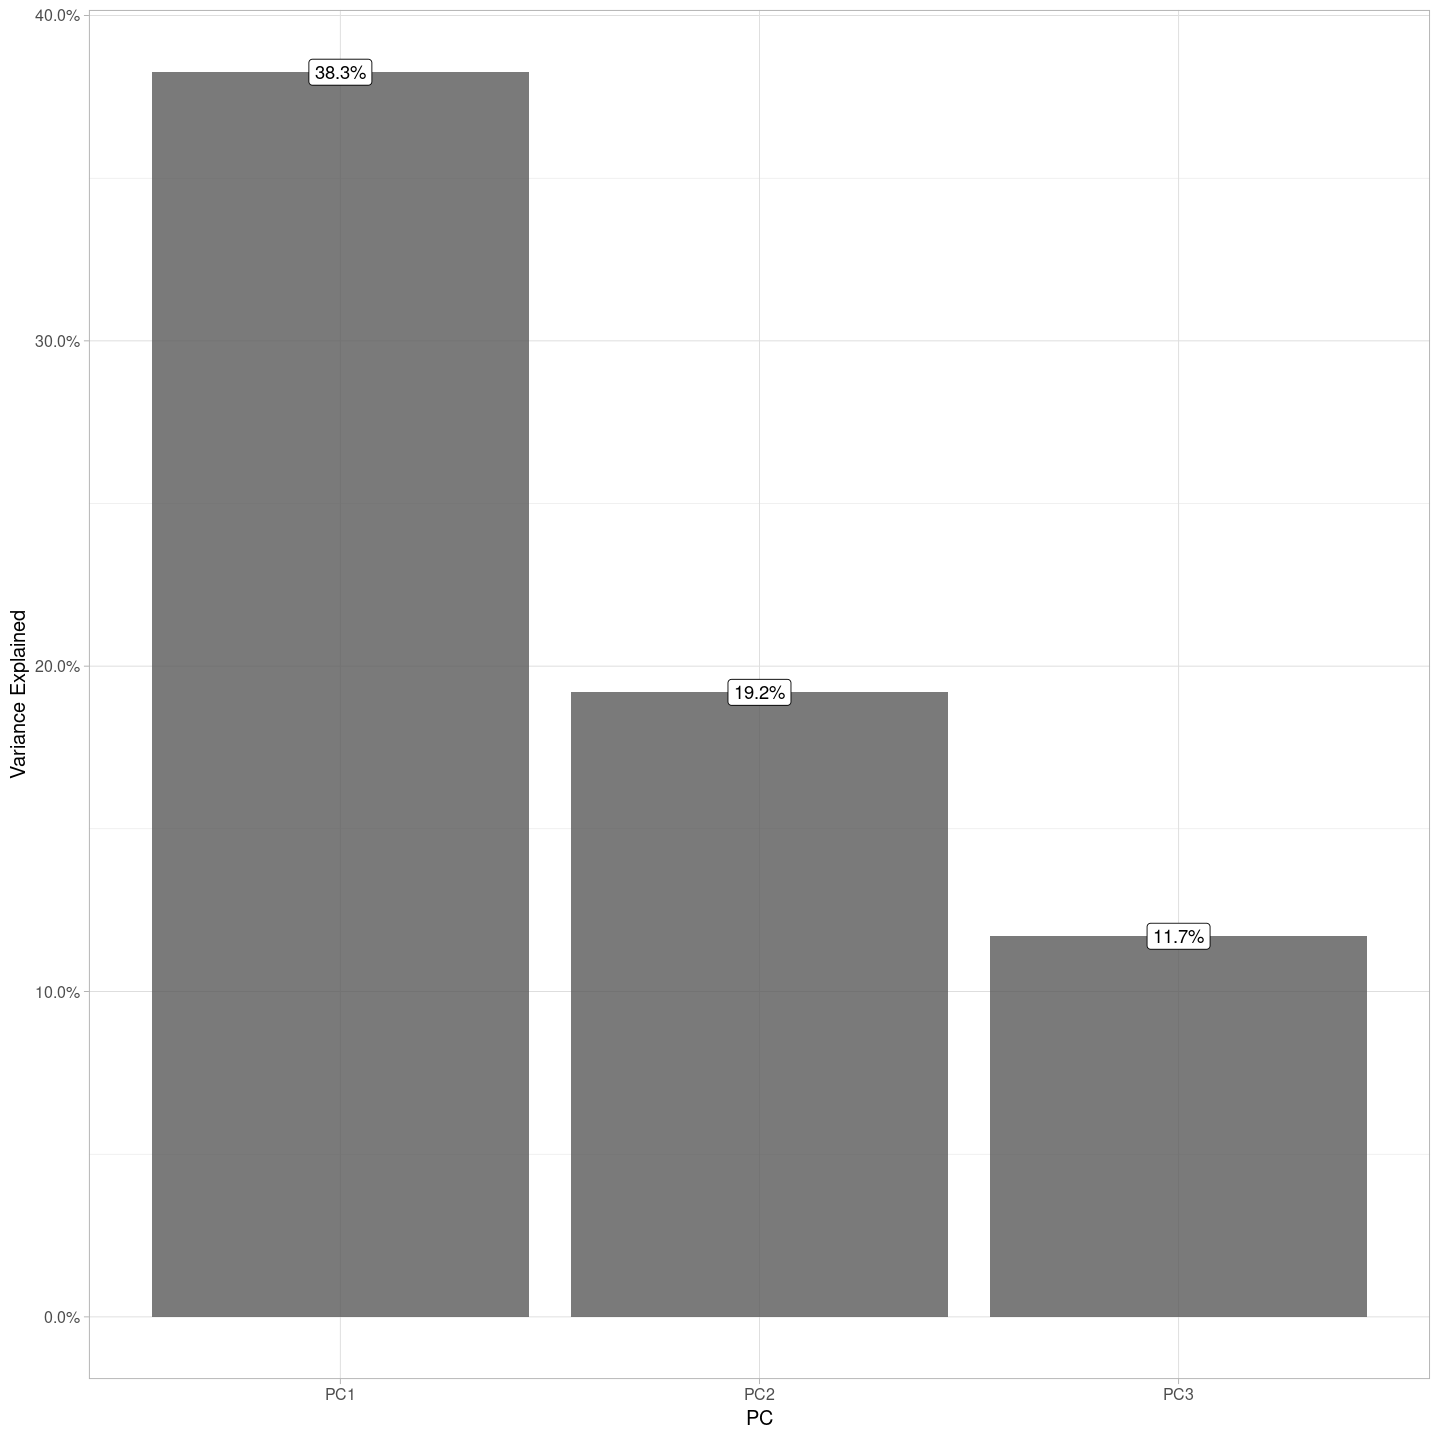

In [44]:
p1 = ggplot(pca1 %>% filter(variable == "variance" & pc %in% c("PC1", "PC2", "PC3"))) +
    geom_bar(aes(x = pc, y = value), stat = "identity", alpha = myalpha) +
    geom_label(aes(x = pc, y = value, label = scales::percent(value))) +
    theme_light(base_size = 12) +
    labs (x = "PC", y = "Variance Explained") +
    scale_y_continuous(labels = scales::percent)
p1

In [45]:
pca2 = data.frame(sample = row.names(m2), pca$x[, 1:4]) %>% inner_join(samples) %>% inner_join(dominant)
head(pca2)

Joining, by = "sample"

inner_join: added 3 columns (accession, project, description)

            > rows only in x  ( 0)

            > rows only in y  ( 0)

            > matched rows     75

            >                 ====

            > rows total       75

Joining, by = "sample"

inner_join: added 2 columns (name, abundance)

            > rows only in x  ( 0)

            > rows only in y  ( 0)

            > matched rows     75

            >                 ====

            > rows total       75



sample    PC1        PC2        PC3       PC4       accession project
1 DRR099940  2.7071938 -2.4543322 -9.918557 -2.249313 PRJDB6156 Osaka  
2 DRR099941 -1.4674415 -0.3854776 -6.757361 -1.921571 PRJDB6156 Osaka  
3 DRR099942  1.1222845 -2.0935522 -9.379059 -2.615701 PRJDB6156 Osaka  
4 DRR099943 -0.9349506 -1.5843115 -6.791122 -2.615625 PRJDB6156 Osaka  
5 DRR099944  4.2742639 -2.1497634 -8.781450 -1.106992 PRJDB6156 Osaka  
6 DRR099945  2.1337239 -2.9579147 -9.149723 -2.151814 PRJDB6156 Osaka  
  description                          name                    abundance
1 Osaka Bay Metatranscriptome (Marine) Bacillus                0.2012053
2 Osaka Bay Metatranscriptome (Marine) Synechococcus           0.2987069
3 Osaka Bay Metatranscriptome (Marine) Pseudomonas             0.1450954
4 Osaka Bay Metatranscriptome (Marine) Candidatus Pelagibacter 0.3125952
5 Osaka Bay Metatranscriptome (Marine) Pseudomonas             0.5568112
6 Osaka Bay Metatranscriptome (Marine) Pseudomonas             0.4064967

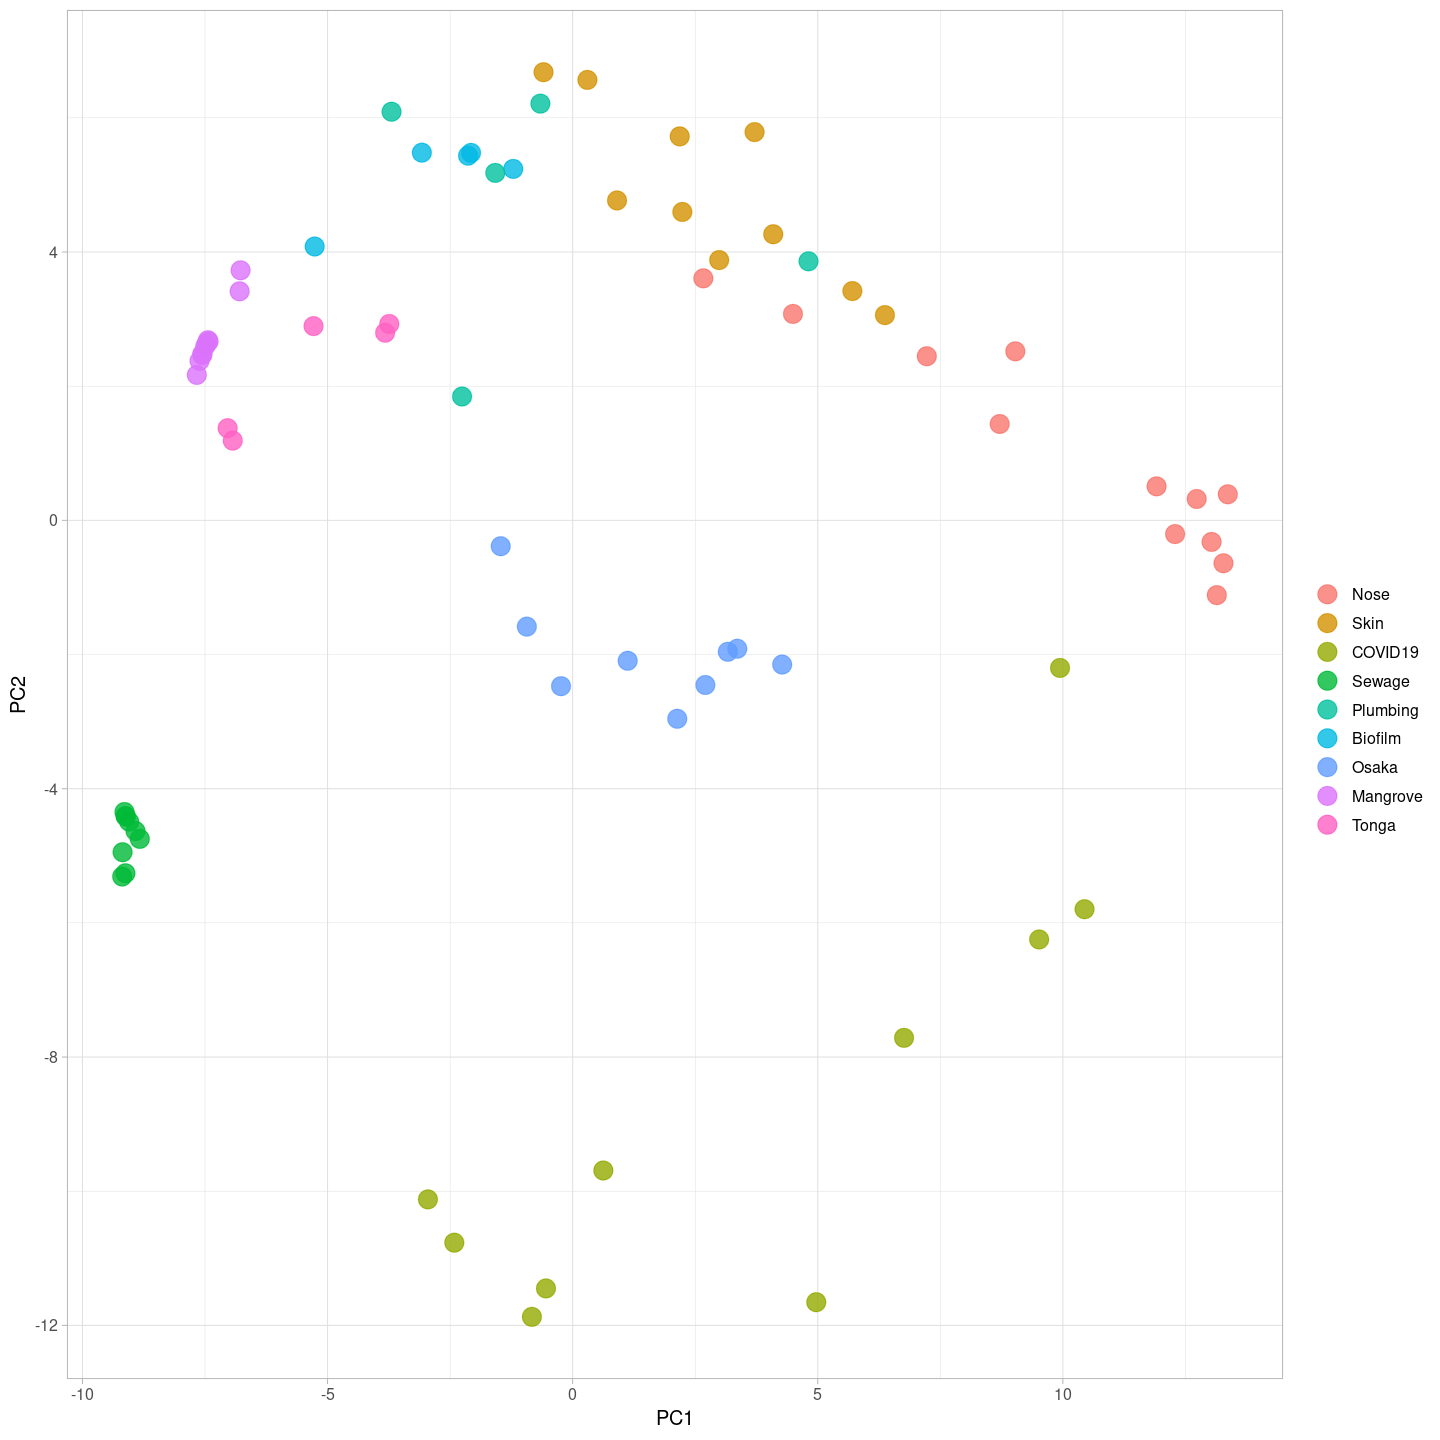

In [46]:
p2 = ggplot(pca2) +
    geom_point(aes(x = PC1, y = PC2, color = project), size = 5, alpha = myalpha) +
    theme_light(base_size = 12) +
    labs (color = "")
p2

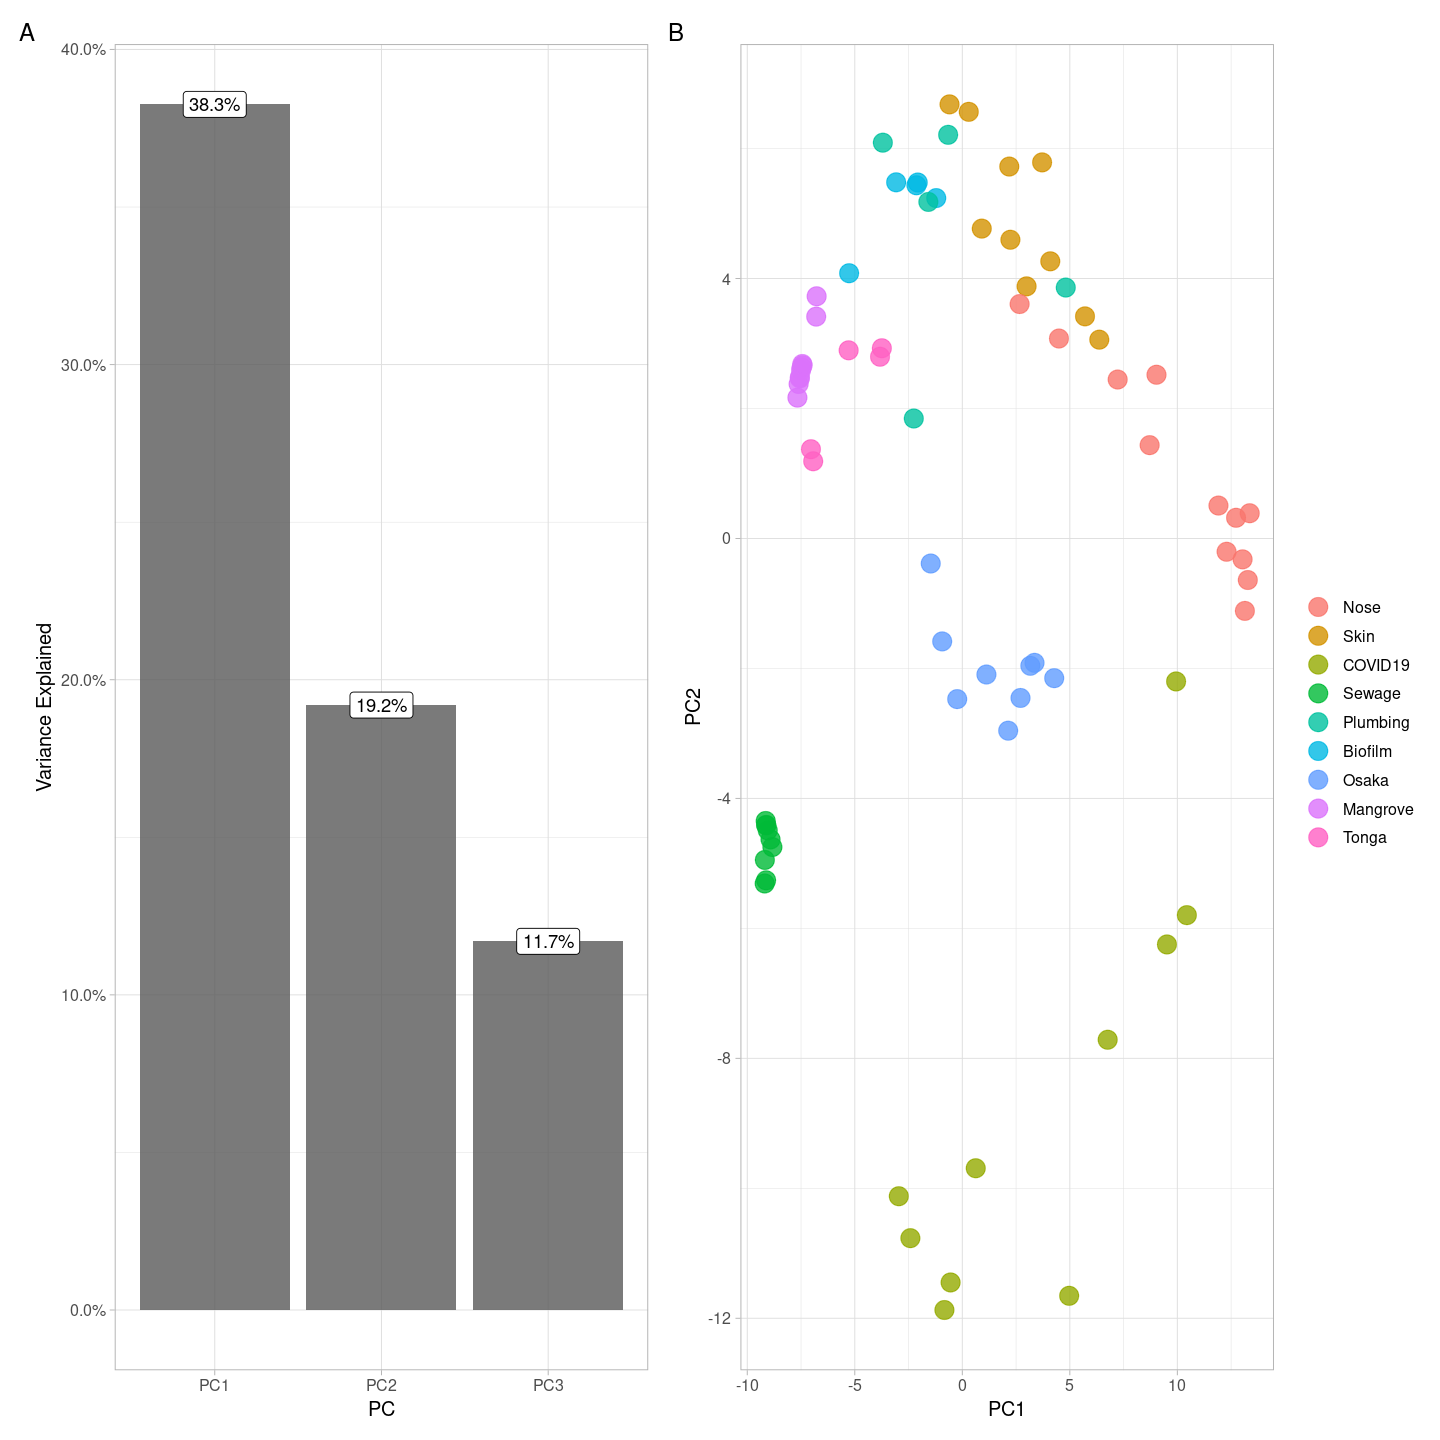

In [47]:
p1 + p2 + plot_annotation(tag_levels = 'A')
ggsave("figs/metaBGC_taxa_pca.pdf", width = 14, height = 7)

# Taxa t-SNE (t-distributed stochastic neighbourhood embedding)

In [48]:
set.seed(1) # for reproducibility
tsne = Rtsne(log10(m2 + 1e-5), dims = 2, perplexity = 20, verbose = TRUE, max_iter = 1000, eta=500)

Performing PCA
Read the 75 x 50 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 2, perplexity = 20.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.00 seconds (sparsity = 0.903467)!
Learning embedding...
Iteration 50: error is 54.748636 (50 iterations in 0.00 seconds)
Iteration 100: error is 57.833329 (50 iterations in 0.00 seconds)
Iteration 150: error is 58.167653 (50 iterations in 0.00 seconds)
Iteration 200: error is 56.038196 (50 iterations in 0.00 seconds)
Iteration 250: error is 57.621817 (50 iterations in 0.00 seconds)
Iteration 300: error is 1.837270 (50 iterations in 0.00 seconds)
Iteration 350: error is 1.602199 (50 iterations in 0.00 seconds)
Iteration 400: error is 1.227018 (50 iterations in 0.00 seconds)
Iteration 450: error is 0.737908 (50 iterations in 0.00 seconds)
Iteration 500: error is 0.601263 (50 iterations in 0.00 seconds)
Iteration 550: error is 0.777549 (50 iterations in 0.00 seconds)
Iteration 600:

In [49]:
str(tsne)

List of 14
 $ N                  : int 75
 $ Y                  : num [1:75, 1:2] 1.57 5.03 7.9 12.82 4.8 ...
 $ costs              : num [1:75] 0.002534 0.005615 -0.000367 0.003877 0.006806 ...
 $ itercosts          : num [1:20] 54.7 57.8 58.2 56 57.6 ...
 $ origD              : int 50
 $ perplexity         : num 20
 $ theta              : num 0.5
 $ max_iter           : num 1000
 $ stop_lying_iter    : int 250
 $ mom_switch_iter    : int 250
 $ momentum           : num 0.5
 $ final_momentum     : num 0.8
 $ eta                : num 500
 $ exaggeration_factor: num 12


In [50]:
tsne2 = data.frame(sample = row.names(m2), x = tsne$Y[, 1], y = tsne$Y[, 2]) %>% inner_join(samples) %>% inner_join(dominant)
head(tsne2)

Joining, by = "sample"

inner_join: added 3 columns (accession, project, description)

            > rows only in x  ( 0)

            > rows only in y  ( 0)

            > matched rows     75

            >                 ====

            > rows total       75

Joining, by = "sample"

inner_join: added 2 columns (name, abundance)

            > rows only in x  ( 0)

            > rows only in y  ( 0)

            > matched rows     75

            >                 ====

            > rows total       75



sample    x         y        accession project
1 DRR099940  1.574202 59.41947 PRJDB6156 Osaka  
2 DRR099941  5.028641 51.74611 PRJDB6156 Osaka  
3 DRR099942  7.901161 59.03608 PRJDB6156 Osaka  
4 DRR099943 12.817643 52.25912 PRJDB6156 Osaka  
5 DRR099944  4.799302 70.52010 PRJDB6156 Osaka  
6 DRR099945 11.860157 65.62010 PRJDB6156 Osaka  
  description                          name                    abundance
1 Osaka Bay Metatranscriptome (Marine) Bacillus                0.2012053
2 Osaka Bay Metatranscriptome (Marine) Synechococcus           0.2987069
3 Osaka Bay Metatranscriptome (Marine) Pseudomonas             0.1450954
4 Osaka Bay Metatranscriptome (Marine) Candidatus Pelagibacter 0.3125952
5 Osaka Bay Metatranscriptome (Marine) Pseudomonas             0.5568112
6 Osaka Bay Metatranscriptome (Marine) Pseudomonas             0.4064967

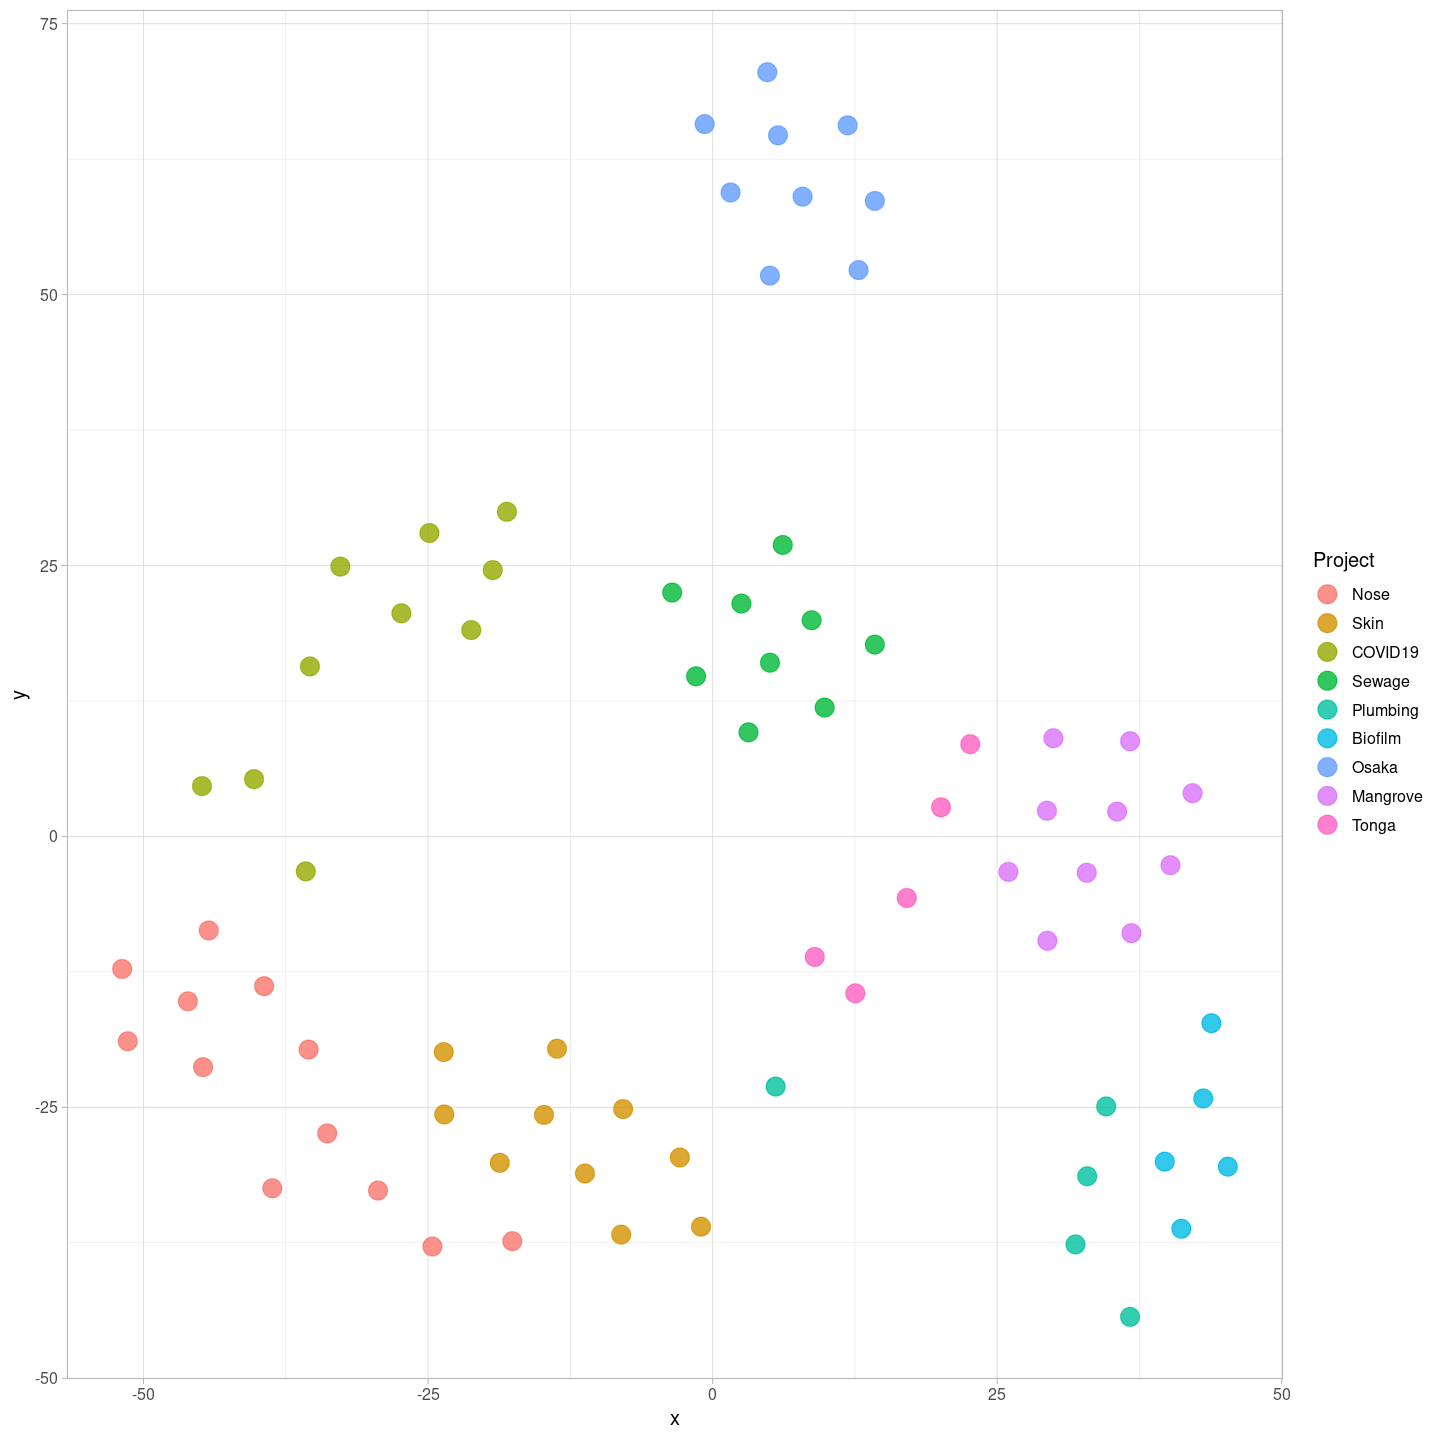

In [51]:
ggplot(tsne2) +
    geom_point(aes(x = x, y = y, color = project), size = 5, alpha = myalpha) +
    theme_light(base_size = 12) +
    labs (color = "Project")
ggsave("figs/metaBGC_taxa_tsne.pdf", width = 7, height = 6)

In [52]:
groups = data.frame (sample = row.names(m2)) %>% inner_join(projects)
head(groups)

Joining, by = "sample"

inner_join: added 3 columns (accession, project, description)

            > rows only in x  ( 0)

            > rows only in y  (43)

            > matched rows     75

            >                 ====

            > rows total       75



sample    accession project description                         
1 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
2 DRR099941 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
3 DRR099942 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
4 DRR099943 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
5 DRR099944 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
6 DRR099945 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)

# Ecological Diversity Indices

## Alpha Diversity

In [53]:
alpha_diversity = data.frame(sample = row.names(m2),
                   Shannon = diversity(m2, "shannon"),
                   Simpson = diversity(m2, "simpson")) %>% inner_join(samples) %>% melt() %>% rename(index = variable)
head(alpha_diversity)

Joining, by = "sample"

inner_join: added 3 columns (accession, project, description)

            > rows only in x  ( 0)

            > rows only in y  ( 0)

            > matched rows     75

            >                 ====

            > rows total       75

Using sample, accession, project, description as id variables

rename: renamed one variable (index)



sample    accession project description                          index  
1 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine) Shannon
2 DRR099941 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine) Shannon
3 DRR099942 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine) Shannon
4 DRR099943 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine) Shannon
5 DRR099944 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine) Shannon
6 DRR099945 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine) Shannon
  value   
1 2.324736
2 2.052278
3 2.407094
4 2.068540
5 1.528747
6 1.903887

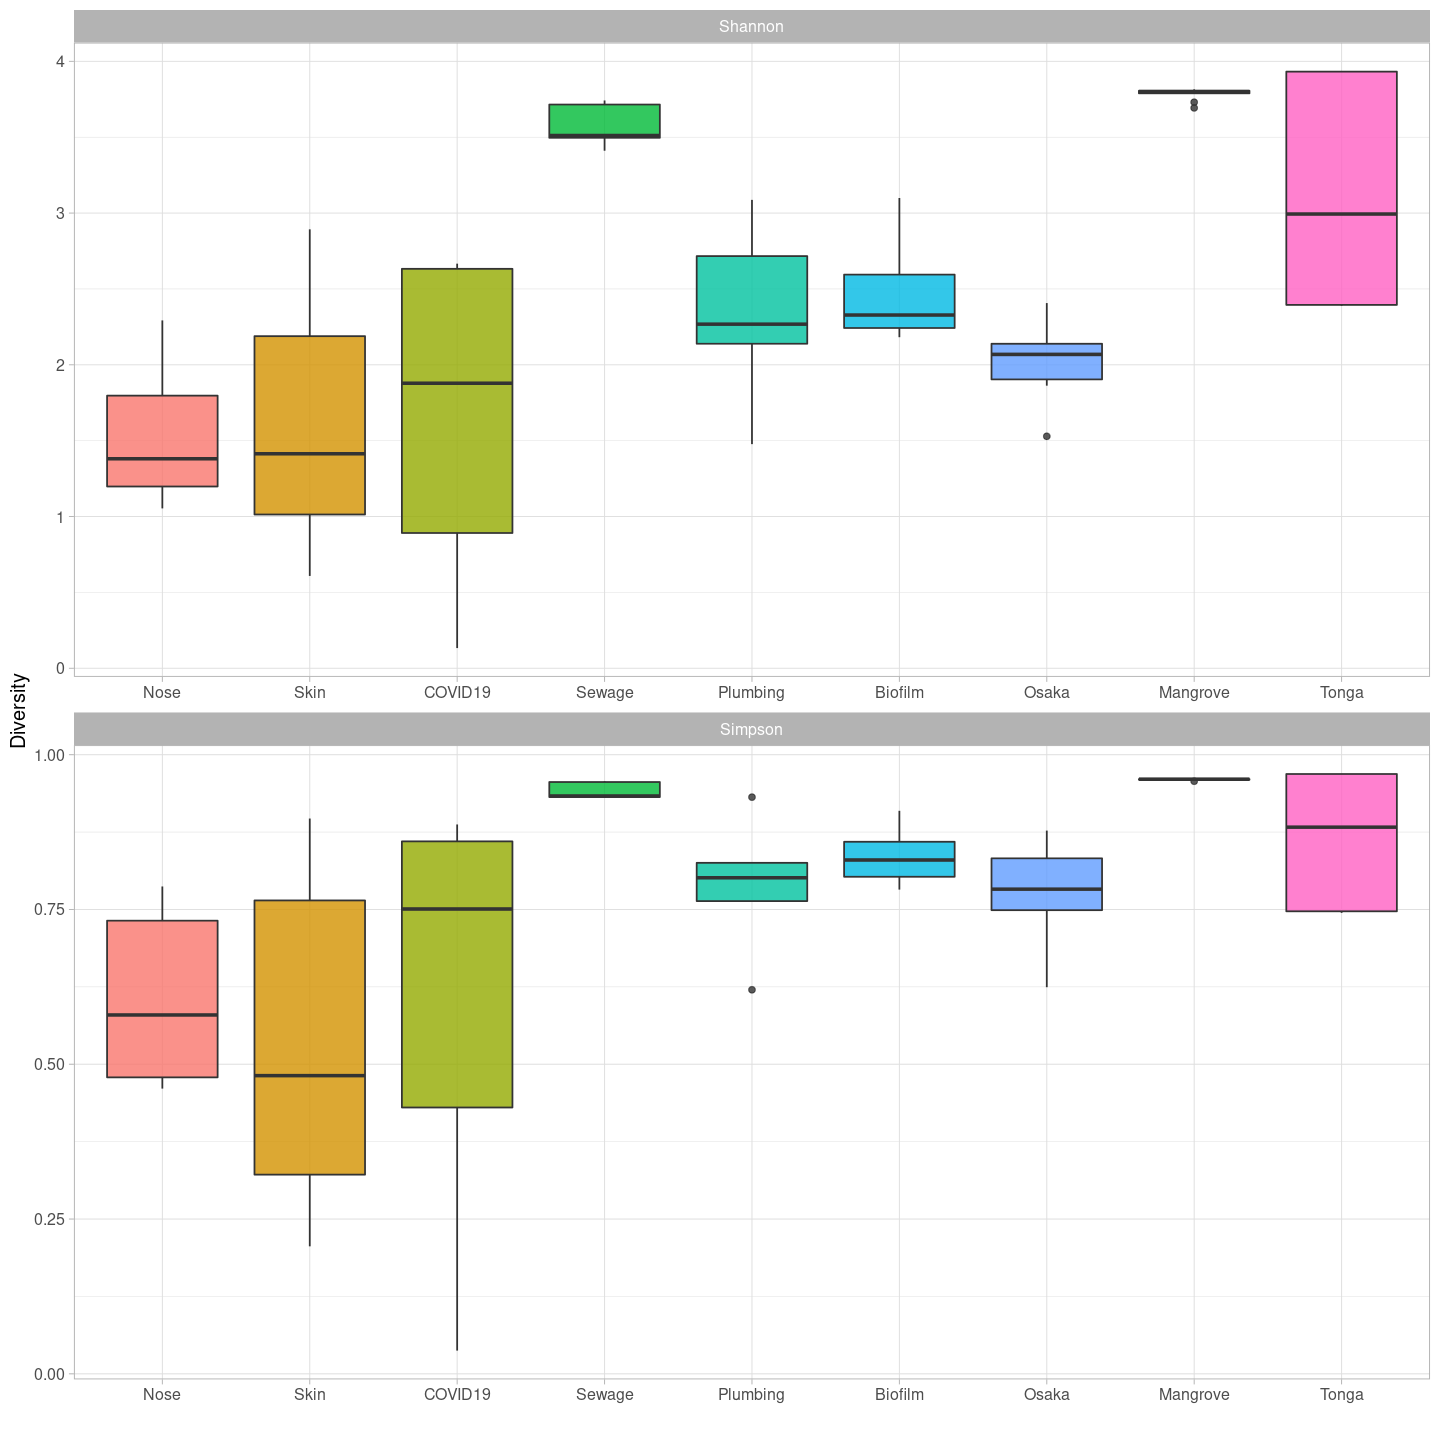

In [54]:
ggplot(alpha_diversity) +
    geom_boxplot(aes (x = project, y = value, fill = project), alpha = myalpha) +
    theme_light(base_size = 12) +
    theme(legend.position = "none") +
    labs (x = "", y = "Diversity") +
    facet_wrap (~index, nrow = 2, scales = "free")
ggsave("figs/metaBGC_diversity_alpha.pdf", width = 10, height = 8)

## Beta Diversity

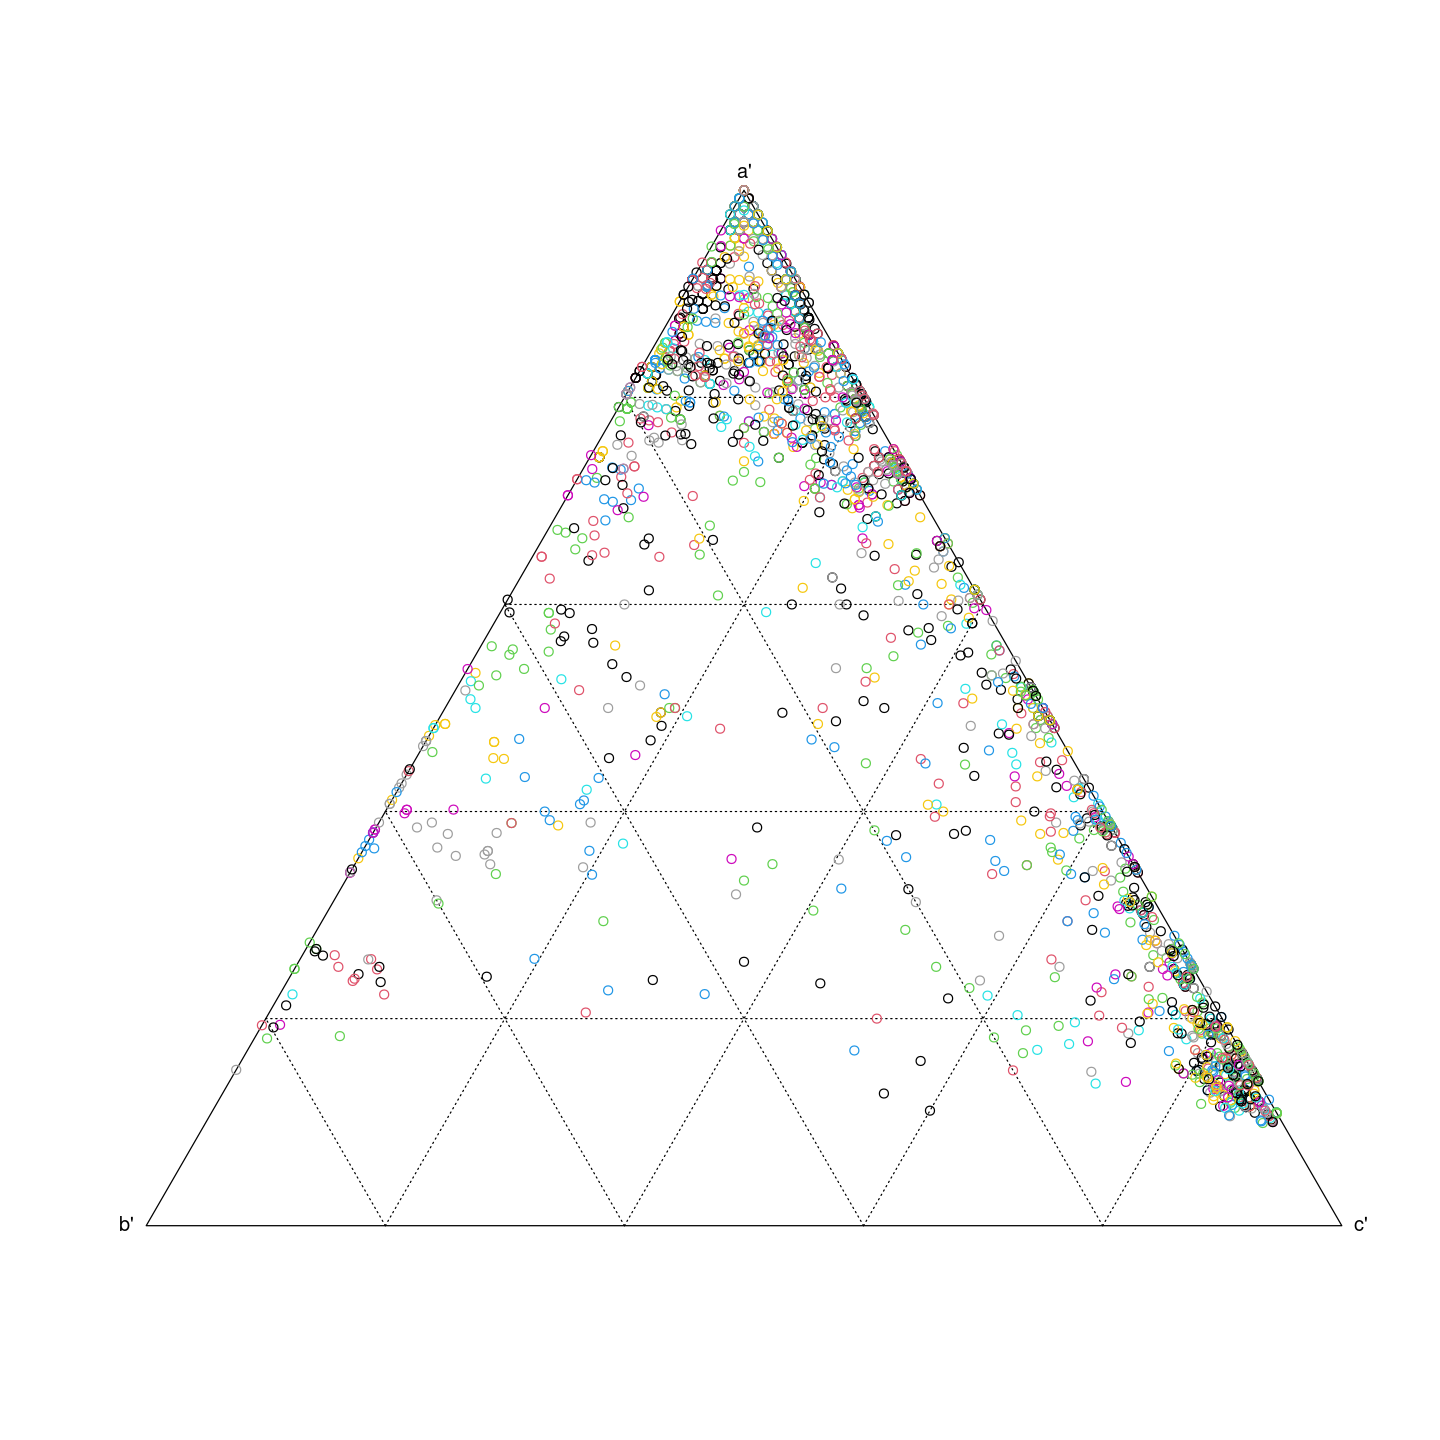

In [55]:
beta1 = betadiver(x = m2, group = groups$project)
plot(beta1, col = factor(groups$project))

In [56]:
dist.mat = as.matrix(vegdist(m2, method = "bray"))
dim(dist.mat)

[1] 75 75

In [57]:
for (i in 1:nrow(dist.mat)) {
    for (j in 1:ncol(dist.mat)) {
        if (i >= j) {
            dist.mat[i, j] = -1
        }
    }
}
dist.df1 = dist.mat %>% melt() %>% rename(sample1 = Var1, sample2 = Var2, dist = value)
head(dist.df1)

rename: renamed 3 variables (sample1, sample2, dist)



sample1   sample2   dist
1 DRR099940 DRR099940 -1  
2 DRR099941 DRR099940 -1  
3 DRR099942 DRR099940 -1  
4 DRR099943 DRR099940 -1  
5 DRR099944 DRR099940 -1  
6 DRR099945 DRR099940 -1

In [58]:
dist.df2 = dist.df1 %>% inner_join(projects, by = c("sample1" = "sample")) %>% rename(project1 = project) %>% inner_join(projects, by = c("sample2" = "sample")) %>% rename(project2 = project)
head(dist.df2)

inner_join: added 3 columns (accession, project, description)

            > rows only in x  (    0)

            > rows only in y  (   43)

            > matched rows     5,625

            >                 =======

            > rows total       5,625

rename: renamed one variable (project1)

inner_join: added 5 columns (accession.x, description.x, accession.y, project, description.y)

            > rows only in x  (    0)

            > rows only in y  (   43)

            > matched rows     5,625

            >                 =======

            > rows total       5,625

rename: renamed one variable (project2)



sample1   sample2   dist accession.x project1
1 DRR099940 DRR099940 -1   PRJDB6156   Osaka   
2 DRR099941 DRR099940 -1   PRJDB6156   Osaka   
3 DRR099942 DRR099940 -1   PRJDB6156   Osaka   
4 DRR099943 DRR099940 -1   PRJDB6156   Osaka   
5 DRR099944 DRR099940 -1   PRJDB6156   Osaka   
6 DRR099945 DRR099940 -1   PRJDB6156   Osaka   
  description.x                        accession.y project2
1 Osaka Bay Metatranscriptome (Marine) PRJDB6156   Osaka   
2 Osaka Bay Metatranscriptome (Marine) PRJDB6156   Osaka   
3 Osaka Bay Metatranscriptome (Marine) PRJDB6156   Osaka   
4 Osaka Bay Metatranscriptome (Marine) PRJDB6156   Osaka   
5 Osaka Bay Metatranscriptome (Marine) PRJDB6156   Osaka   
6 Osaka Bay Metatranscriptome (Marine) PRJDB6156   Osaka   
  description.y                       
1 Osaka Bay Metatranscriptome (Marine)
2 Osaka Bay Metatranscriptome (Marine)
3 Osaka Bay Metatranscriptome (Marine)
4 Osaka Bay Metatranscriptome (Marine)
5 Osaka Bay Metatranscriptome (Marine)
6 Osaka Bay Metatranscriptome (Marine)

In [59]:
dist.df3 = dist.df2 %>% filter(sample1 != sample2 & dist != -1) %>% mutate(index = "bray")
head(dist.df3)

filter: removed 2,850 rows (51%), 2,775 rows remaining

mutate: new variable 'index' (character) with one unique value and 0% NA



sample1   sample2   dist      accession.x project1
1 DRR099940 DRR099941 0.6462886 PRJDB6156   Osaka   
2 DRR099940 DRR099942 0.2021917 PRJDB6156   Osaka   
3 DRR099941 DRR099942 0.5096888 PRJDB6156   Osaka   
4 DRR099940 DRR099943 0.7445355 PRJDB6156   Osaka   
5 DRR099941 DRR099943 0.4594621 PRJDB6156   Osaka   
6 DRR099942 DRR099943 0.5663856 PRJDB6156   Osaka   
  description.x                        accession.y project2
1 Osaka Bay Metatranscriptome (Marine) PRJDB6156   Osaka   
2 Osaka Bay Metatranscriptome (Marine) PRJDB6156   Osaka   
3 Osaka Bay Metatranscriptome (Marine) PRJDB6156   Osaka   
4 Osaka Bay Metatranscriptome (Marine) PRJDB6156   Osaka   
5 Osaka Bay Metatranscriptome (Marine) PRJDB6156   Osaka   
6 Osaka Bay Metatranscriptome (Marine) PRJDB6156   Osaka   
  description.y                        index
1 Osaka Bay Metatranscriptome (Marine) bray 
2 Osaka Bay Metatranscriptome (Marine) bray 
3 Osaka Bay Metatranscriptome (Marine) bray 
4 Osaka Bay Metatranscriptome (Marine) bray 
5 Osaka Bay Metatranscriptome (Marine) bray 
6 Osaka Bay Metatranscriptome (Marine) bray

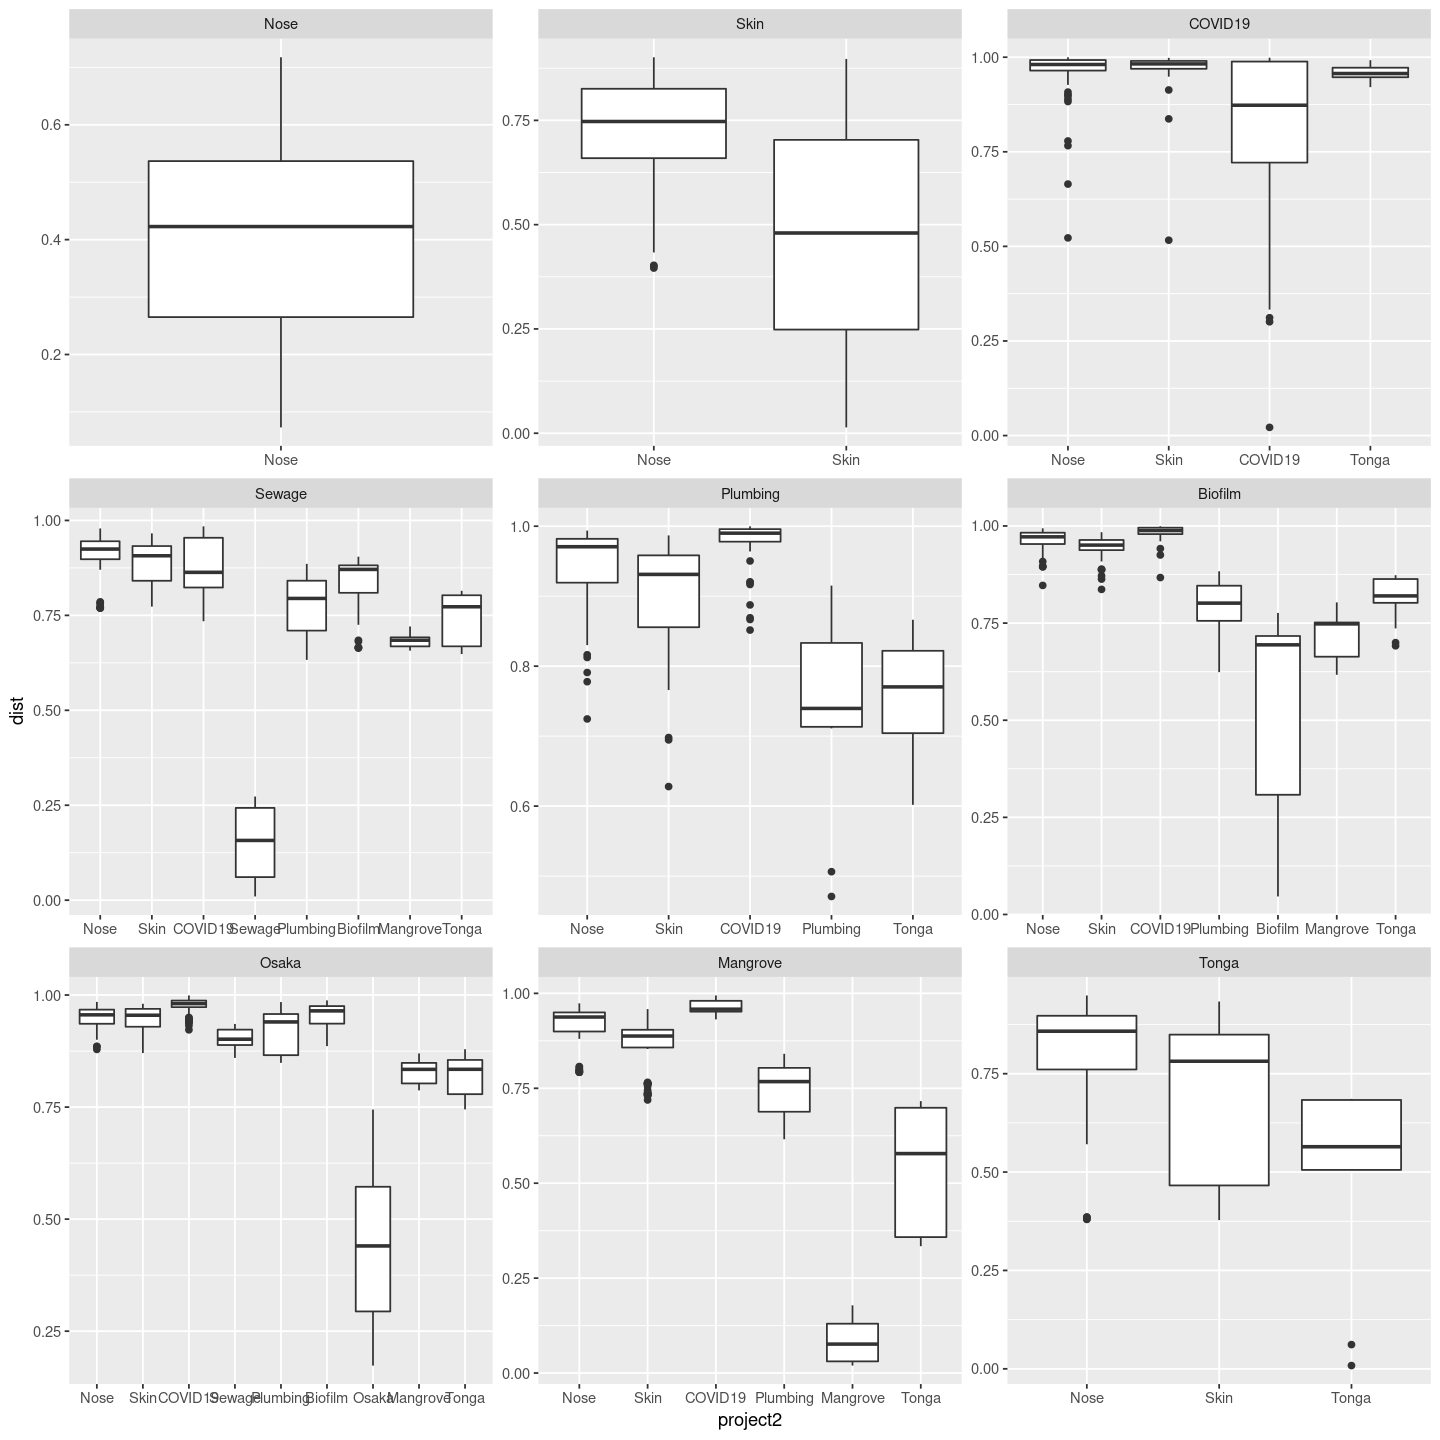

In [60]:
ggplot(dist.df3) +
    geom_boxplot(aes(x = project2, y = dist)) +
    facet_wrap(~project1, scale = "free")

In [61]:
dist.df4 = dist.df3 %>% group_by(project1, project2) %>% summarise(dist = median(dist))
head(dist.df4)

group_by: 2 grouping variables (project1, project2)

summarise: now 45 rows and 3 columns, one group variable remaining (project1)



project1 project2 dist     
1 Nose     Nose     0.4227582
2 Skin     Nose     0.7472900
3 Skin     Skin     0.4800109
4 COVID19  Nose     0.9807534
5 COVID19  Skin     0.9823259
6 COVID19  COVID19  0.8730504

filter (grouped): removed 9 rows (20%), 36 rows remaining



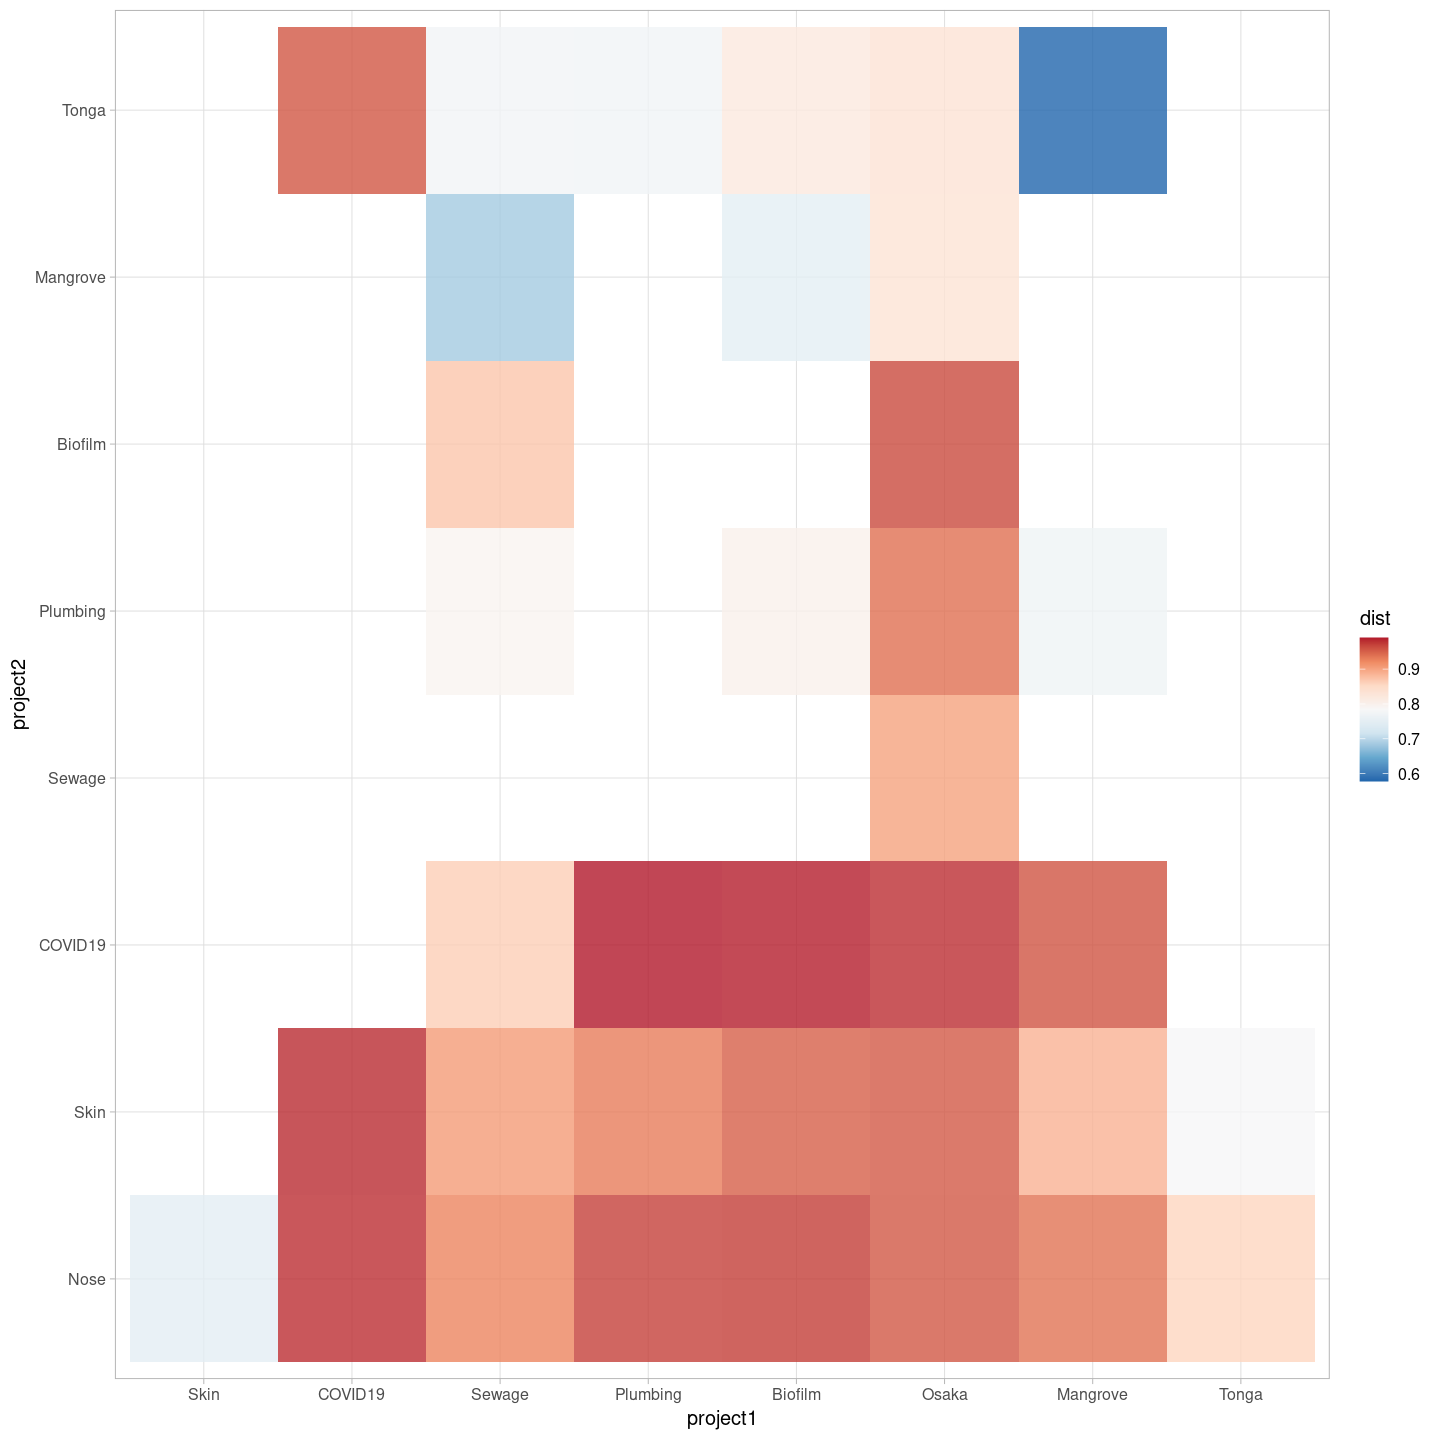

In [62]:
ggplot(dist.df4 %>% filter(project1 != project2)) +
    geom_tile(aes (x = project1, y = project2, fill = dist), alpha = myalpha) +
    theme_light(base_size = 12) +
    scale_fill_distiller(palette = "RdBu")

## BGC

In [63]:
contigs.taxa = read_tsv("tables/contigs.taxonomy.full.tsv.gz")
head(contigs.taxa)


── Column specification ────────────────────────────────────────────────────────
cols(
  sample = col_character(),
  contig = col_character(),
  taxid = col_double(),
  name = col_character(),
  species = col_character(),
  genus = col_character(),
  family = col_character(),
  order = col_character(),
  class = col_character(),
  phylum = col_character(),
  superkingdom = col_character()
)




sample    contig   taxid   name                                          
1 DRR099940 k79_6666 1268635 Legionella oakridgensis ATCC 33761 = DSM 21215
2 DRR099940 k79_3256 2598861 Bacillus miscanthi                            
3 DRR099940 k79_2204  110662 Synechococcus sp. CC9605                      
4 DRR099940 k79_705  1579316 Halocynthiibacter arcticus                    
5 DRR099940 k79_8320    1491 Clostridium botulinum                         
6 DRR099940 k79_7801 1898749 Candidatus Nitrosomarinus catalina            
  species                            genus                    
1 Legionella oakridgensis            Legionella               
2 Bacillus miscanthi                 Bacillus                 
3 Synechococcus sp. CC9605           Synechococcus            
4 Halocynthiibacter arcticus         Halocynthiibacter        
5 Clostridium botulinum              Clostridium              
6 Candidatus Nitrosomarinus catalina Candidatus Nitrosomarinus
  family            order            class                       phylum        
1 Legionellaceae    Legionellales    Gammaproteobacteria         Proteobacteria
2 Bacillaceae       Bacillales       Bacilli                     Firmicutes    
3 Synechococcaceae  Synechococcales  Unclassified Cyanobacteria  Cyanobacteria 
4 Rhodobacteraceae  Rhodobacterales  Alphaproteobacteria         Proteobacteria
5 Clostridiaceae    Clostridiales    Clostridia                  Firmicutes    
6 Nitrosopumilaceae Nitrosopumilales Unclassified Thaumarchaeota Thaumarchaeota
  superkingdom
1 Bacteria    
2 Bacteria    
3 Bacteria    
4 Bacteria    
5 Bacteria    
6 Archaea

## antiSmash

In [64]:
antismash = read_tsv("tables/antismash.tsv") %>% inner_join(contigs.taxa)
head(antismash)


── Column specification ────────────────────────────────────────────────────────
cols(
  sample = col_character(),
  contig = col_character(),
  antismash_region = col_character(),
  region_start = col_double(),
  region_end = col_double(),
  taxid = col_double(),
  name = col_character()
)


Joining, by = c("sample", "contig", "taxid", "name")

inner_join: added 7 columns (species, genus, family, order, class, …)

            > rows only in x  (     85)

            > rows only in y  (355,097)

            > matched rows       1,231

            >                 =========

            > rows total         1,231



sample    contig    antismash_region region_start region_end taxid  
1 DRR099941 k79_3879  bacteriocin        1          2013        166314
2 DRR099941 k79_41141 terpene            1          6830        232348
3 DRR099941 k79_18924 bacteriocin        1          3493        166314
4 DRR099941 k79_31519 terpene            1          1370        110662
5 DRR099941 k79_24749 bacteriocin        1          4050       1783272
6 DRR099941 k79_19051 bacteriocin      574          6709       2511069
  name                       species                    genus                
1 Synechococcus sp. WH 8109  Synechococcus sp. WH 8109  Synechococcus        
2 Synechococcus sp. CB0101   Synechococcus sp. CB0101   Synechococcus        
3 Synechococcus sp. WH 8109  Synechococcus sp. WH 8109  Synechococcus        
4 Synechococcus sp. CC9605   Synechococcus sp. CC9605   Synechococcus        
5 Terrabacteria group        Unclassified Bacteria      Unclassified Bacteria
6 Synechococcus sp. RSCCF101 Synechococcus sp. RSCCF101 Synechococcus        
  family                order                 class                     
1 Synechococcaceae      Synechococcales       Unclassified Cyanobacteria
2 Synechococcaceae      Synechococcales       Unclassified Cyanobacteria
3 Synechococcaceae      Synechococcales       Unclassified Cyanobacteria
4 Synechococcaceae      Synechococcales       Unclassified Cyanobacteria
5 Unclassified Bacteria Unclassified Bacteria Unclassified Bacteria     
6 Synechococcaceae      Synechococcales       Unclassified Cyanobacteria
  phylum                superkingdom
1 Cyanobacteria         Bacteria    
2 Cyanobacteria         Bacteria    
3 Cyanobacteria         Bacteria    
4 Cyanobacteria         Bacteria    
5 Unclassified Bacteria Bacteria    
6 Cyanobacteria         Bacteria

In [65]:
antismash2 = antismash %>% inner_join(contigs.taxa) %>% filter (!(name %in% human))
head(antismash2)

Joining, by = c("sample", "contig", "taxid", "name", "species", "genus", "family", "order", "class", "phylum", "superkingdom")

inner_join: added no columns

            > rows only in x  (      0)

            > rows only in y  (355,097)

            > matched rows       1,231

            >                 =========

            > rows total         1,231

filter: no rows removed



sample    contig    antismash_region region_start region_end taxid  
1 DRR099941 k79_3879  bacteriocin        1          2013        166314
2 DRR099941 k79_41141 terpene            1          6830        232348
3 DRR099941 k79_18924 bacteriocin        1          3493        166314
4 DRR099941 k79_31519 terpene            1          1370        110662
5 DRR099941 k79_24749 bacteriocin        1          4050       1783272
6 DRR099941 k79_19051 bacteriocin      574          6709       2511069
  name                       species                    genus                
1 Synechococcus sp. WH 8109  Synechococcus sp. WH 8109  Synechococcus        
2 Synechococcus sp. CB0101   Synechococcus sp. CB0101   Synechococcus        
3 Synechococcus sp. WH 8109  Synechococcus sp. WH 8109  Synechococcus        
4 Synechococcus sp. CC9605   Synechococcus sp. CC9605   Synechococcus        
5 Terrabacteria group        Unclassified Bacteria      Unclassified Bacteria
6 Synechococcus sp. RSCCF101 Synechococcus sp. RSCCF101 Synechococcus        
  family                order                 class                     
1 Synechococcaceae      Synechococcales       Unclassified Cyanobacteria
2 Synechococcaceae      Synechococcales       Unclassified Cyanobacteria
3 Synechococcaceae      Synechococcales       Unclassified Cyanobacteria
4 Synechococcaceae      Synechococcales       Unclassified Cyanobacteria
5 Unclassified Bacteria Unclassified Bacteria Unclassified Bacteria     
6 Synechococcaceae      Synechococcales       Unclassified Cyanobacteria
  phylum                superkingdom
1 Cyanobacteria         Bacteria    
2 Cyanobacteria         Bacteria    
3 Cyanobacteria         Bacteria    
4 Cyanobacteria         Bacteria    
5 Unclassified Bacteria Bacteria    
6 Cyanobacteria         Bacteria

In [66]:
antismash3 = antismash2 %>% select(sample, contig, antismash_region, genus) %>% rename (name = genus) %>% inner_join(t4 %>% select(sample, name, abundance))
head(antismash3)

select: dropped 10 variables (region_start, region_end, taxid, name, species, …)

rename: renamed one variable (name)

select: dropped 9 variables (accession, project, description, taxonomy_id, taxonomy_lvl, …)

Joining, by = c("sample", "name")

inner_join: added one column (abundance)

            > rows only in x  (  222)

            > rows only in y  (8,893)

            > matched rows     1,009

            >                 =======

            > rows total       1,009



sample    contig    antismash_region name          abundance
1 DRR099941 k79_3879  bacteriocin      Synechococcus 0.2987069
2 DRR099941 k79_41141 terpene          Synechococcus 0.2987069
3 DRR099941 k79_18924 bacteriocin      Synechococcus 0.2987069
4 DRR099941 k79_31519 terpene          Synechococcus 0.2987069
5 DRR099941 k79_19051 bacteriocin      Synechococcus 0.2987069
6 DRR099941 k79_43768 bacteriocin      Synechococcus 0.2987069

In [67]:
head(t4)

sample    accession project description                         
1 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
2 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
3 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
4 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
5 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
6 DRR099940 PRJDB6156 Osaka   Osaka Bay Metatranscriptome (Marine)
  name                         taxonomy_id taxonomy_lvl kraken_assigned_reads
1 Candidatus Prometheoarchaeum 2732160     G               182               
2 Candidatus Pelagibacter       198251     G             40969               
3 Candidatus Nitrosomarinus    1993653     G             25598               
4 Candidatus Mancarchaeum      2490204     G                10               
5 Bacillus                        1386     G             65545               
6 Halomonas                       2745     G            156080               
  added_reads new_est_reads fraction_total_reads abundance   
1 110332      110514        0.10700              1.200790e-01
2   8555       49524        0.04795              5.381111e-02
3   7872       33470        0.03240              3.636037e-02
4      0          10        0.00001              1.122234e-05
5 119636      185181        0.17929              2.012053e-01
6  17257      173337        0.16782              1.883333e-01

In [68]:
antismash4 = antismash3 %>% select(-contig) %>% distinct() %>% inner_join(samples)
head(antismash4)

select: dropped one variable (contig)

distinct: removed 403 rows (40%), 606 rows remaining

Joining, by = "sample"

inner_join: added 3 columns (accession, project, description)

            > rows only in x  (  0)

            > rows only in y  ( 23)

            > matched rows     606

            >                 =====

            > rows total       606



sample    antismash_region name                    abundance accession
1 DRR099941 bacteriocin      Synechococcus           0.2987069 PRJDB6156
2 DRR099941 terpene          Synechococcus           0.2987069 PRJDB6156
3 DRR099943 terpene          Candidatus Pelagibacter 0.3125952 PRJDB6156
4 DRR099944 bacteriocin      Pseudomonas             0.5568112 PRJDB6156
5 DRR099944 NRPS             Pseudomonas             0.5568112 PRJDB6156
6 DRR099944 siderophore      Pseudomonas             0.5568112 PRJDB6156
  project description                         
1 Osaka   Osaka Bay Metatranscriptome (Marine)
2 Osaka   Osaka Bay Metatranscriptome (Marine)
3 Osaka   Osaka Bay Metatranscriptome (Marine)
4 Osaka   Osaka Bay Metatranscriptome (Marine)
5 Osaka   Osaka Bay Metatranscriptome (Marine)
6 Osaka   Osaka Bay Metatranscriptome (Marine)

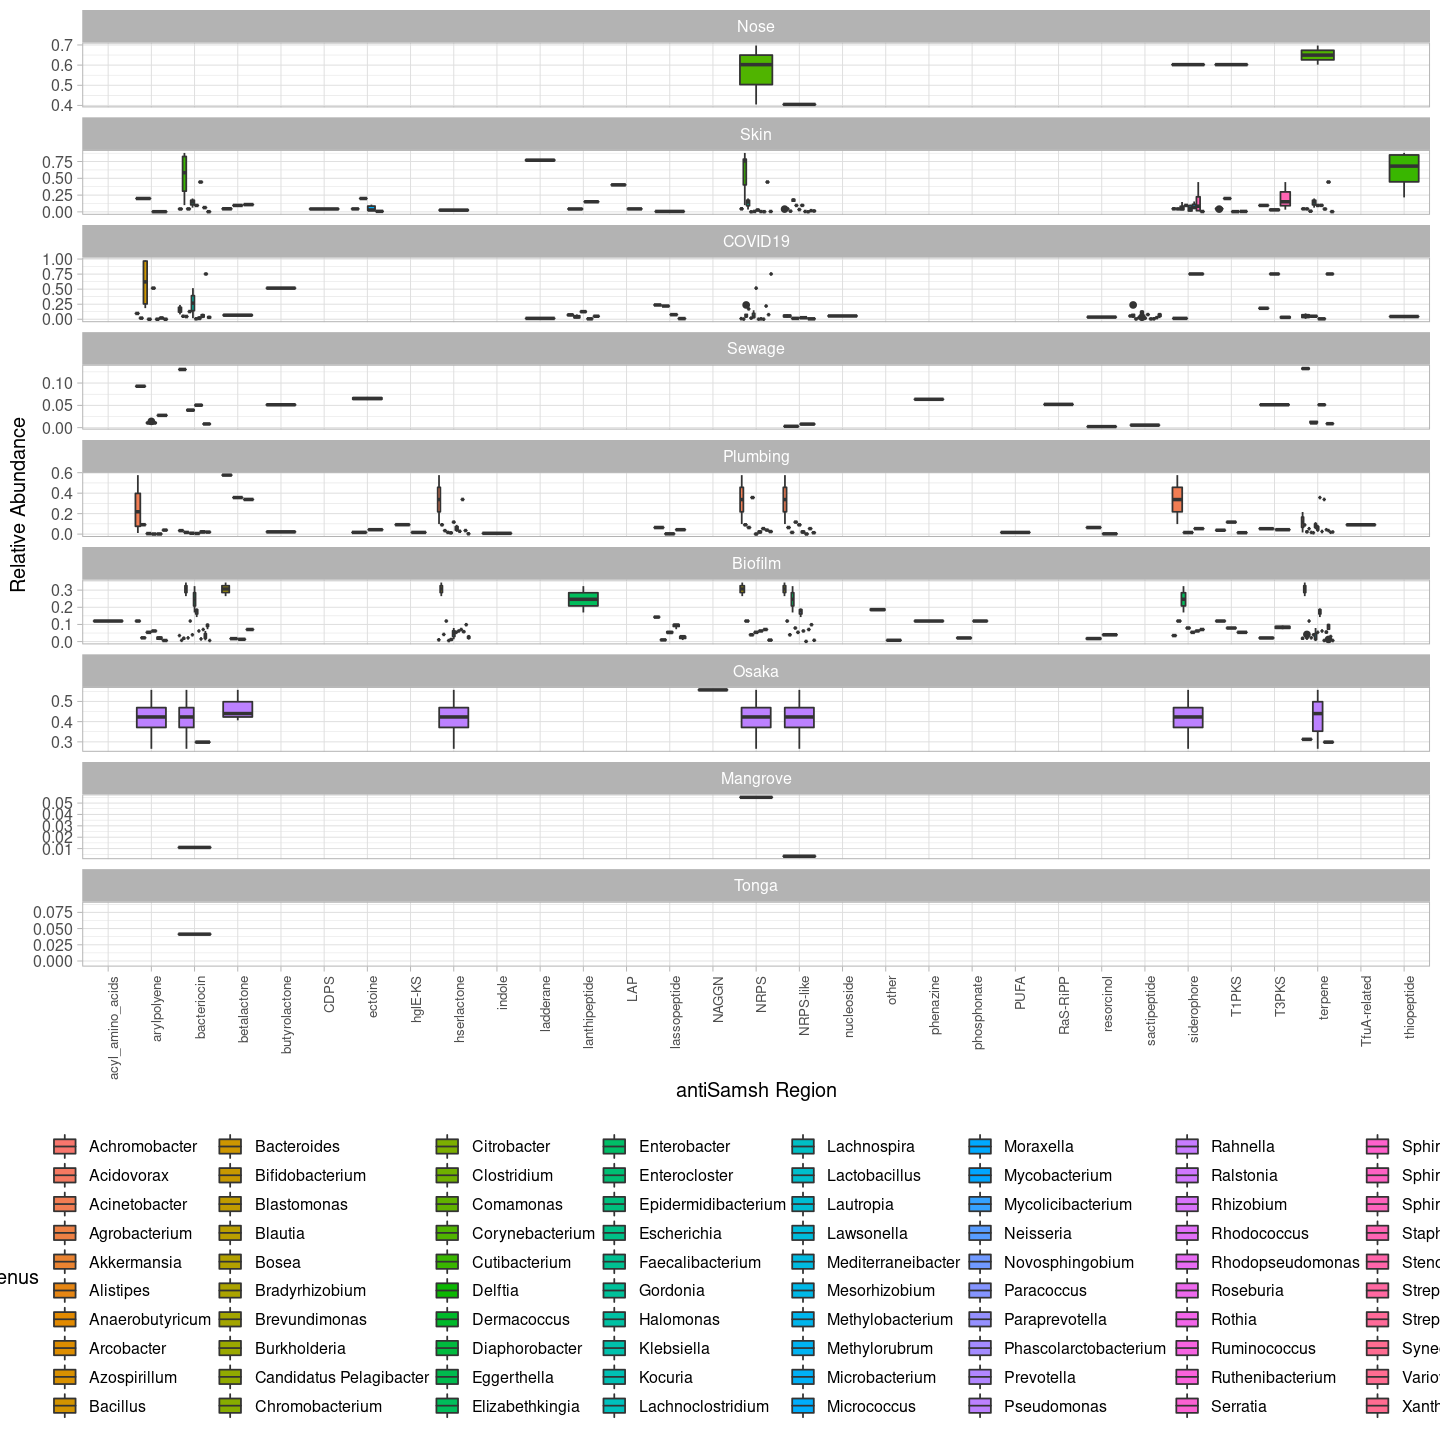

In [69]:
ggplot(antismash4) +
    geom_boxplot(aes(x = antismash_region, y = abundance, fill = name)) +
    theme_light(base_size = 12) +
    facet_wrap (~project, scales = "free_y", ncol = 1) +
    theme(legend.position = "bottom") +
    labs (x = "antiSamsh Region", y = "Relative Abundance", fill = "Genus") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8)) +
    guides(fill = guide_legend(ncol = 8))
ggsave("figs/metaBGC_bgc_antismash_v1.pdf", width = 16, height = 18)

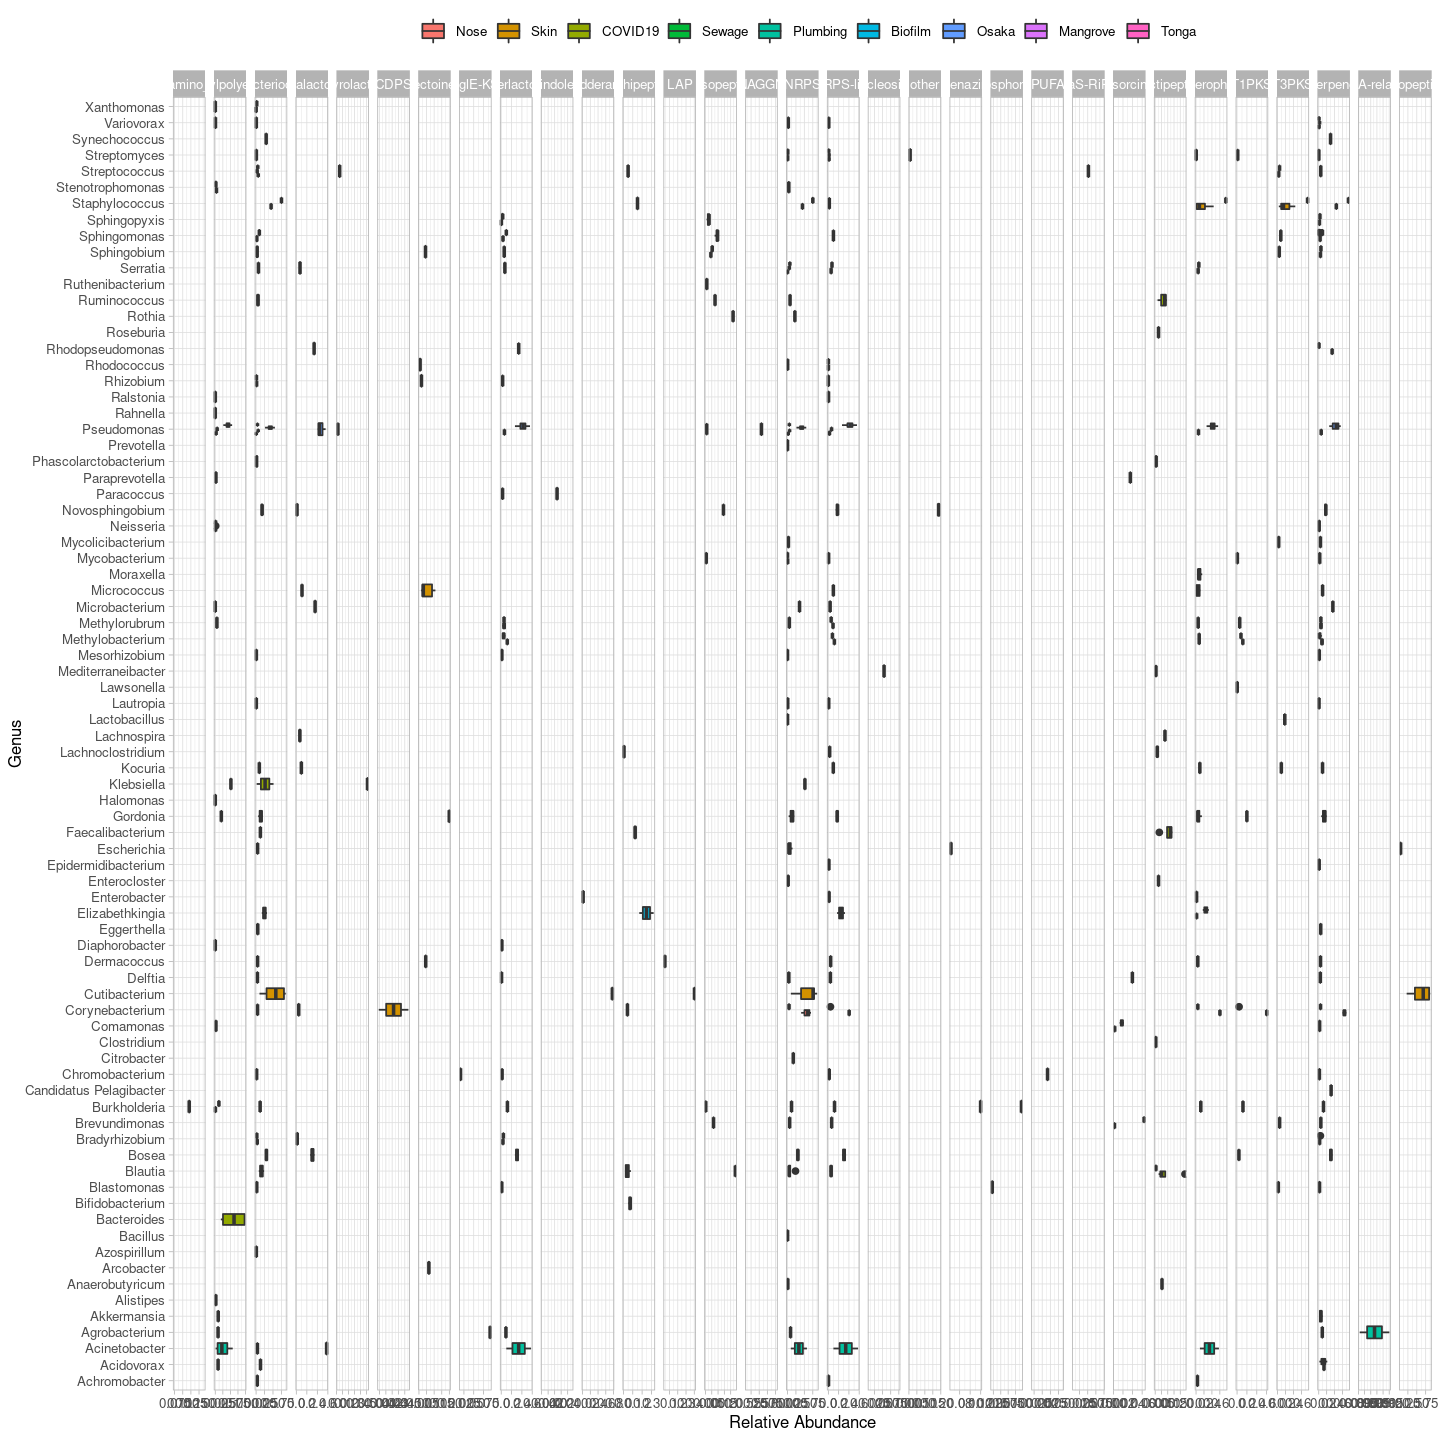

In [70]:
ggplot(antismash4) +
    geom_boxplot(aes(x = abundance, y = name, fill = project)) +
    theme_light(base_size = 10) +
    facet_wrap (~antismash_region, scales = "free_x", nrow = 1) +
    labs (x = "Relative Abundance", y = "Genus", fill = "") +
    theme(legend.position = "top") +
    guides(fill = guide_legend(nrow = 1))
ggsave("figs/metaBGC_bgc_antismash_v2.pdf", width = 18, height = 18)

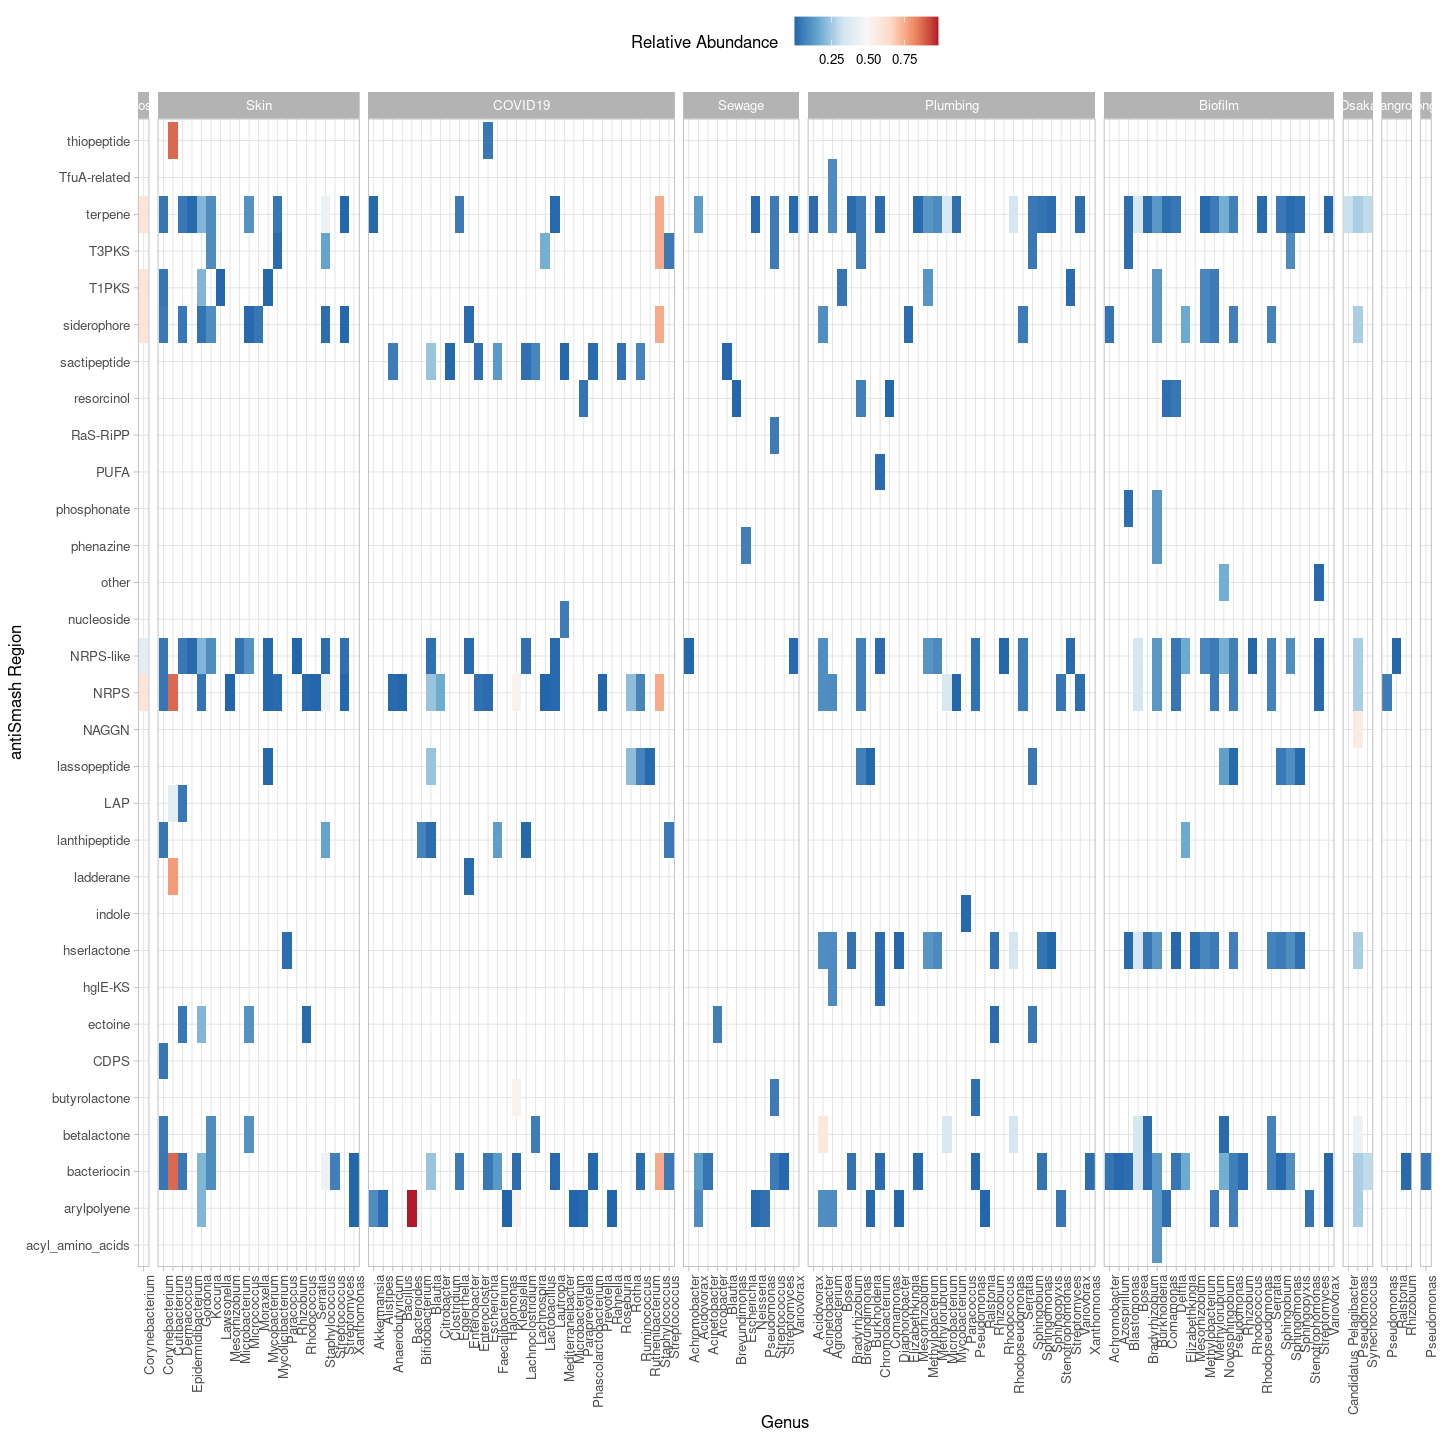

In [71]:
ggplot(antismash4) +
    geom_tile(aes(x = name, y = antismash_region, fill = abundance)) +
    theme_light(base_size = 10) +
    facet_grid (~project, scales = "free_x", space = "free") +
    labs (x = "Genus", y = "antiSmash Region", fill = "Relative Abundance") +
    theme(legend.position = "top") +
    scale_fill_distiller(palette = "RdBu") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8))
ggsave("figs/metaBGC_bgc_antismash_v3.pdf", width = 20, height = 10)

## deepBGC

In [72]:
deepbgc = read_tsv("tables/deepbgc.tsv")
head(deepbgc)


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  sample = col_character(),
  contig = col_character(),
  bgc_candidate_id = col_character(),
  product_activity = col_character(),
  product_class = col_character(),
  name = col_character()
)
ℹ Use `spec()` for the full column specifications.




sample    contig   bgc_candidate_id  nucl_start nucl_end nucl_length
1 DRR099940 k79_704  k79_704_2-1178.1  2          1178     1176       
2 DRR099940 k79_529  k79_529_2-1124.1  2          1124     1122       
3 DRR099940 k79_4315 k79_4315_0-867.1  0           867      867       
4 DRR099940 k79_7624 k79_7624_2-1208.1 2          1208     1206       
5 DRR099940 k79_5368 k79_5368_1-1285.1 1          1285     1284       
6 DRR099940 k79_6585 k79_6585_0-1245.1 0          1245     1245       
  num_proteins deepbgc_score product_activity antibacterial ⋯ product_class
1 1            0.51266       antibacterial    0.87          ⋯ NA           
2 1            0.50891       antibacterial    0.87          ⋯ NA           
3 1            0.51266       antibacterial    0.87          ⋯ NA           
4 2            0.52545       antibacterial    0.87          ⋯ NA           
5 1            0.72042       antibacterial    0.87          ⋯ NA           
6 1            0.54751       antibacterial    0.87          ⋯ NA           
  Alkaloid NRP  Other Polyketide RiPP Saccharide Terpene taxid  
1 0        0.08 0.09  0.29       0.25 0.03       0.31         NA
2 0        0.08 0.08  0.27       0.29 0.03       0.29         NA
3 0        0.08 0.09  0.29       0.25 0.03       0.31         NA
4 0        0.09 0.07  0.33       0.21 0.03       0.32    2500547
5 0        0.09 0.06  0.36       0.19 0.03       0.32         NA
6 0        0.09 0.07  0.33       0.21 0.03       0.32     166314
  name                     
1 NA                       
2 NA                       
3 NA                       
4 Apibacter sp. HY041      
5 NA                       
6 Synechococcus sp. WH 8109

In [73]:
deepbgc2 = deepbgc %>% inner_join(contigs.taxa) %>% filter (!(name %in% human))
head(deepbgc2)

Joining, by = c("sample", "contig", "taxid", "name")

inner_join: added 7 columns (species, genus, family, order, class, …)

            > rows only in x  ( 21,196)

            > rows only in y  (257,376)

            > matched rows     102,922

            >                 =========

            > rows total       102,922

filter: no rows removed



sample    contig   bgc_candidate_id    nucl_start nucl_end nucl_length
1 DRR099940 k79_7624 k79_7624_2-1208.1     2        1208     1206       
2 DRR099940 k79_6585 k79_6585_0-1245.1     0        1245     1245       
3 DRR099940 k79_2471 k79_2471_0-471.1      0         471      471       
4 DRR099940 k79_3174 k79_3174_0-1062.1     0        1062     1062       
5 DRR099940 k79_3716 k79_3716_103-1477.1 103        1477     1374       
6 DRR099940 k79_1419 k79_1419_62-1484.1   62        1484     1422       
  num_proteins deepbgc_score product_activity antibacterial ⋯ Terpene taxid  
1 2            0.52545       antibacterial    0.87          ⋯ 0.32    2500547
2 1            0.54751       antibacterial    0.87          ⋯ 0.32     166314
3 1            0.51307       antibacterial    0.87          ⋯ 0.32     196896
4 1            0.57135       antibacterial    0.87          ⋯ 0.32      63737
5 1            0.50891       antibacterial    0.87          ⋯ 0.29    2058133
6 1            0.57097       antibacterial    0.87          ⋯ 0.32       1118
  name                         species                   
1 Apibacter sp. HY041          Apibacter raozihei        
2 Synechococcus sp. WH 8109    Synechococcus sp. WH 8109 
3 unclassified Myoviridae      Unclassified Myoviridae   
4 Nostoc punctiforme PCC 73102 Nostoc punctiforme        
5 Alteromonas sp. MB-3u-76     Alteromonas sp. MB-3u-76  
6 Chroococcales                Unclassified Chroococcales
  genus                      family                     order           
1 Apibacter                  Weeksellaceae              Flavobacteriales
2 Synechococcus              Synechococcaceae           Synechococcales 
3 Unclassified Myoviridae    Myoviridae                 Caudovirales    
4 Nostoc                     Nostocaceae                Nostocales      
5 Alteromonas                Alteromonadaceae           Alteromonadales 
6 Unclassified Chroococcales Unclassified Chroococcales Chroococcales   
  class                      phylum         superkingdom
1 Flavobacteriia             Bacteroidetes  Bacteria    
2 Unclassified Cyanobacteria Cyanobacteria  Bacteria    
3 Caudoviricetes             Uroviricota    Viruses     
4 Unclassified Cyanobacteria Cyanobacteria  Bacteria    
5 Gammaproteobacteria        Proteobacteria Bacteria    
6 Unclassified Cyanobacteria Cyanobacteria  Bacteria

In [74]:
deepbgc3 = deepbgc2 %>% select(sample, contig, product_activity, genus) %>% rename (name = genus) %>% inner_join(t4 %>% select(sample, name, abundance))
head(deepbgc3)

select: dropped 26 variables (bgc_candidate_id, nucl_start, nucl_end, nucl_length, num_proteins, …)

rename: renamed one variable (name)

select: dropped 9 variables (accession, project, description, taxonomy_id, taxonomy_lvl, …)

Joining, by = c("sample", "name")

inner_join: added one column (abundance)

            > rows only in x  (28,426)

            > rows only in y  ( 7,080)

            > matched rows     74,496

            >                 ========

            > rows total       74,496



sample    contig   product_activity name          abundance   
1 DRR099940 k79_6585 antibacterial    Synechococcus 0.0187413027
2 DRR099940 k79_3174 antibacterial    Nostoc        0.0009314540
3 DRR099940 k79_7215 antibacterial    Sulfitobacter 0.0018516856
4 DRR099940 k79_643  antibacterial    Polaribacter  0.0005050052
5 DRR099940 k79_820  antibacterial    Synechococcus 0.0187413027
6 DRR099940 k79_4519 antibacterial    Synechococcus 0.0187413027

In [75]:
deepbgc4 = deepbgc3 %>% select(-contig) %>% distinct() %>% inner_join(samples)
head(deepbgc4)

select: dropped one variable (contig)

distinct: removed 71,118 rows (95%), 3,378 rows remaining

Joining, by = "sample"

inner_join: added 3 columns (accession, project, description)

            > rows only in x  (    0)

            > rows only in y  (    5)

            > matched rows     3,378

            >                 =======

            > rows total       3,378



sample    product_activity name                      abundance    accession
1 DRR099940 antibacterial    Synechococcus             0.0187413027 PRJDB6156
2 DRR099940 antibacterial    Nostoc                    0.0009314540 PRJDB6156
3 DRR099940 antibacterial    Sulfitobacter             0.0018516856 PRJDB6156
4 DRR099940 antibacterial    Polaribacter              0.0005050052 PRJDB6156
5 DRR099940 antibacterial    Pseudomonas               0.0678165821 PRJDB6156
6 DRR099940 antibacterial    Candidatus Nitrosomarinus 0.0363603717 PRJDB6156
  project description                         
1 Osaka   Osaka Bay Metatranscriptome (Marine)
2 Osaka   Osaka Bay Metatranscriptome (Marine)
3 Osaka   Osaka Bay Metatranscriptome (Marine)
4 Osaka   Osaka Bay Metatranscriptome (Marine)
5 Osaka   Osaka Bay Metatranscriptome (Marine)
6 Osaka   Osaka Bay Metatranscriptome (Marine)

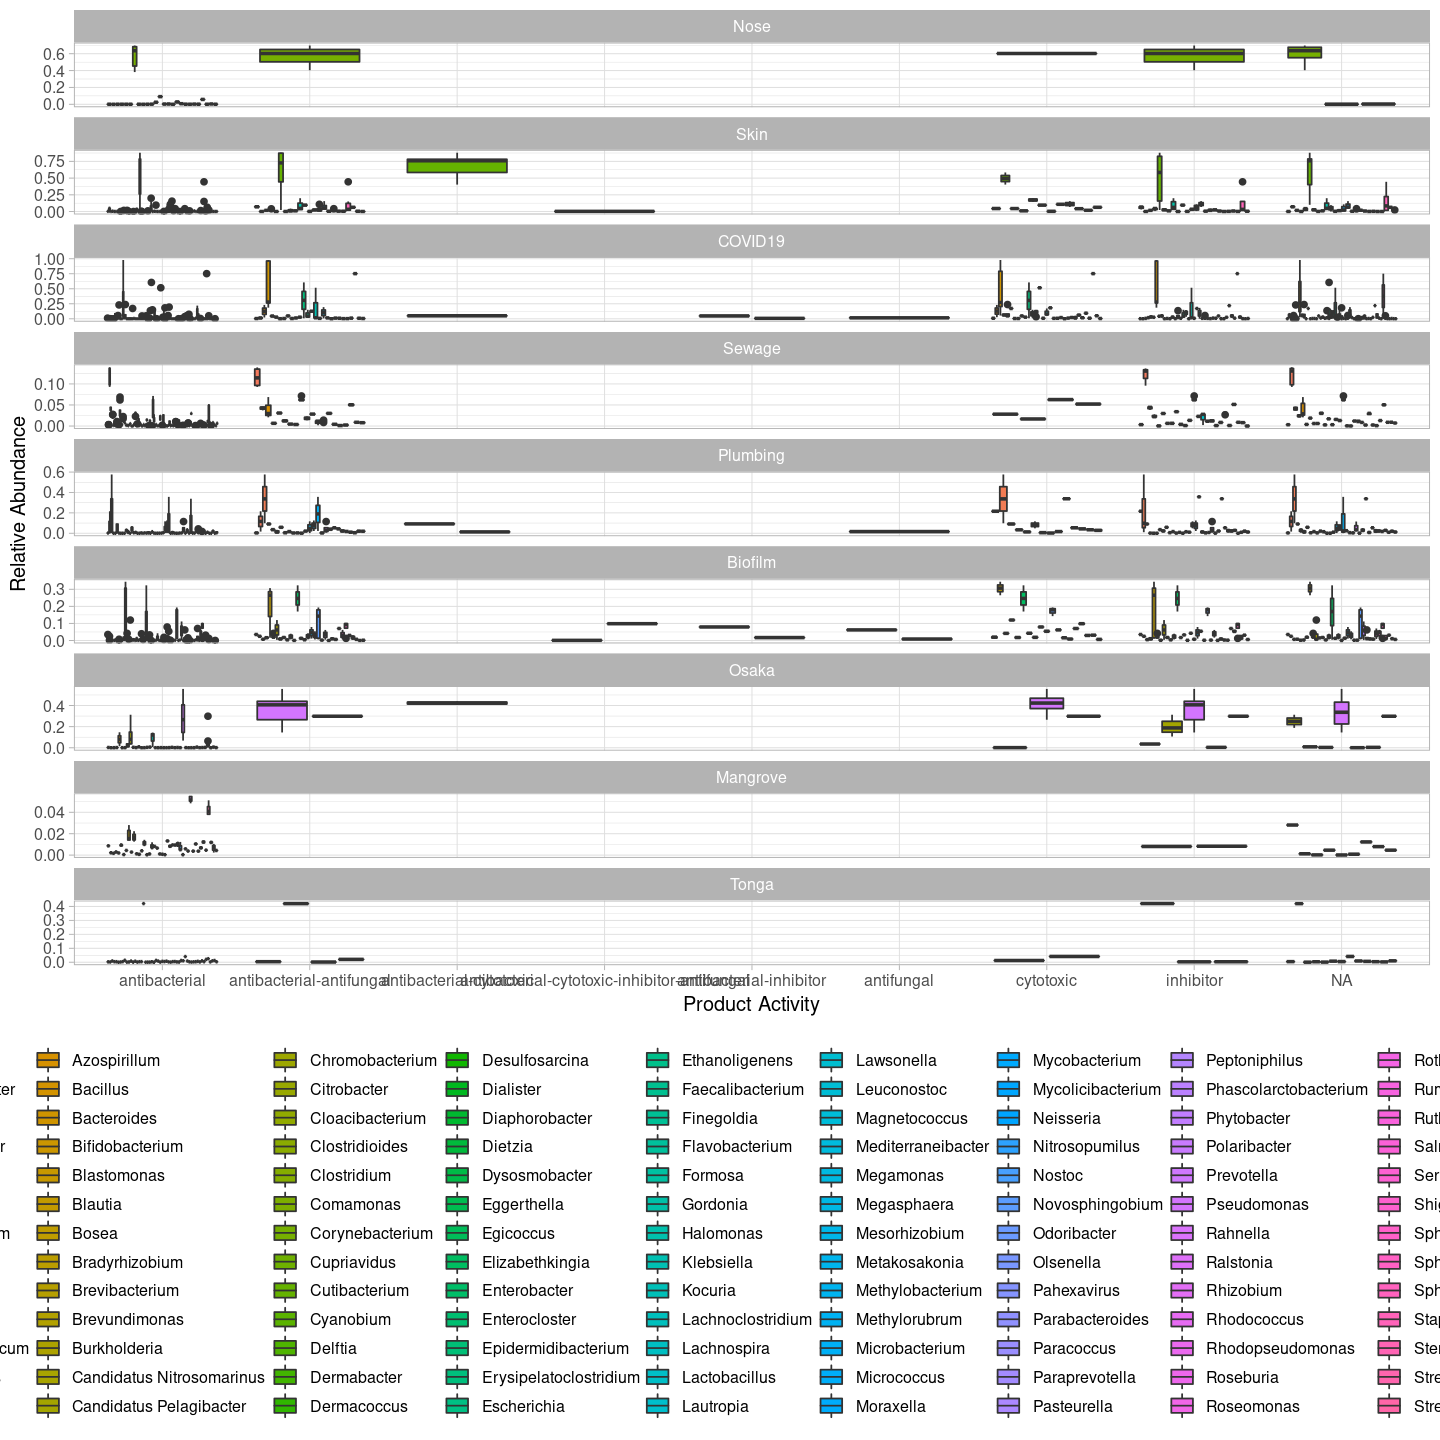

In [76]:
ggplot(deepbgc4) +
    geom_boxplot(aes(x = product_activity, y = abundance, fill = name)) +
    theme_light(base_size = 12) +
    facet_wrap (~project, scales = "free_y", ncol = 1) +
    theme(legend.position = "bottom") +
    labs (x = "Product Activity", y = "Relative Abundance", fill = "Genus") +
    guides(fill = guide_legend(ncol = 10))
ggsave("figs/metaBGC_bgc_deepbgc_v1.pdf", width = 20, height = 18)

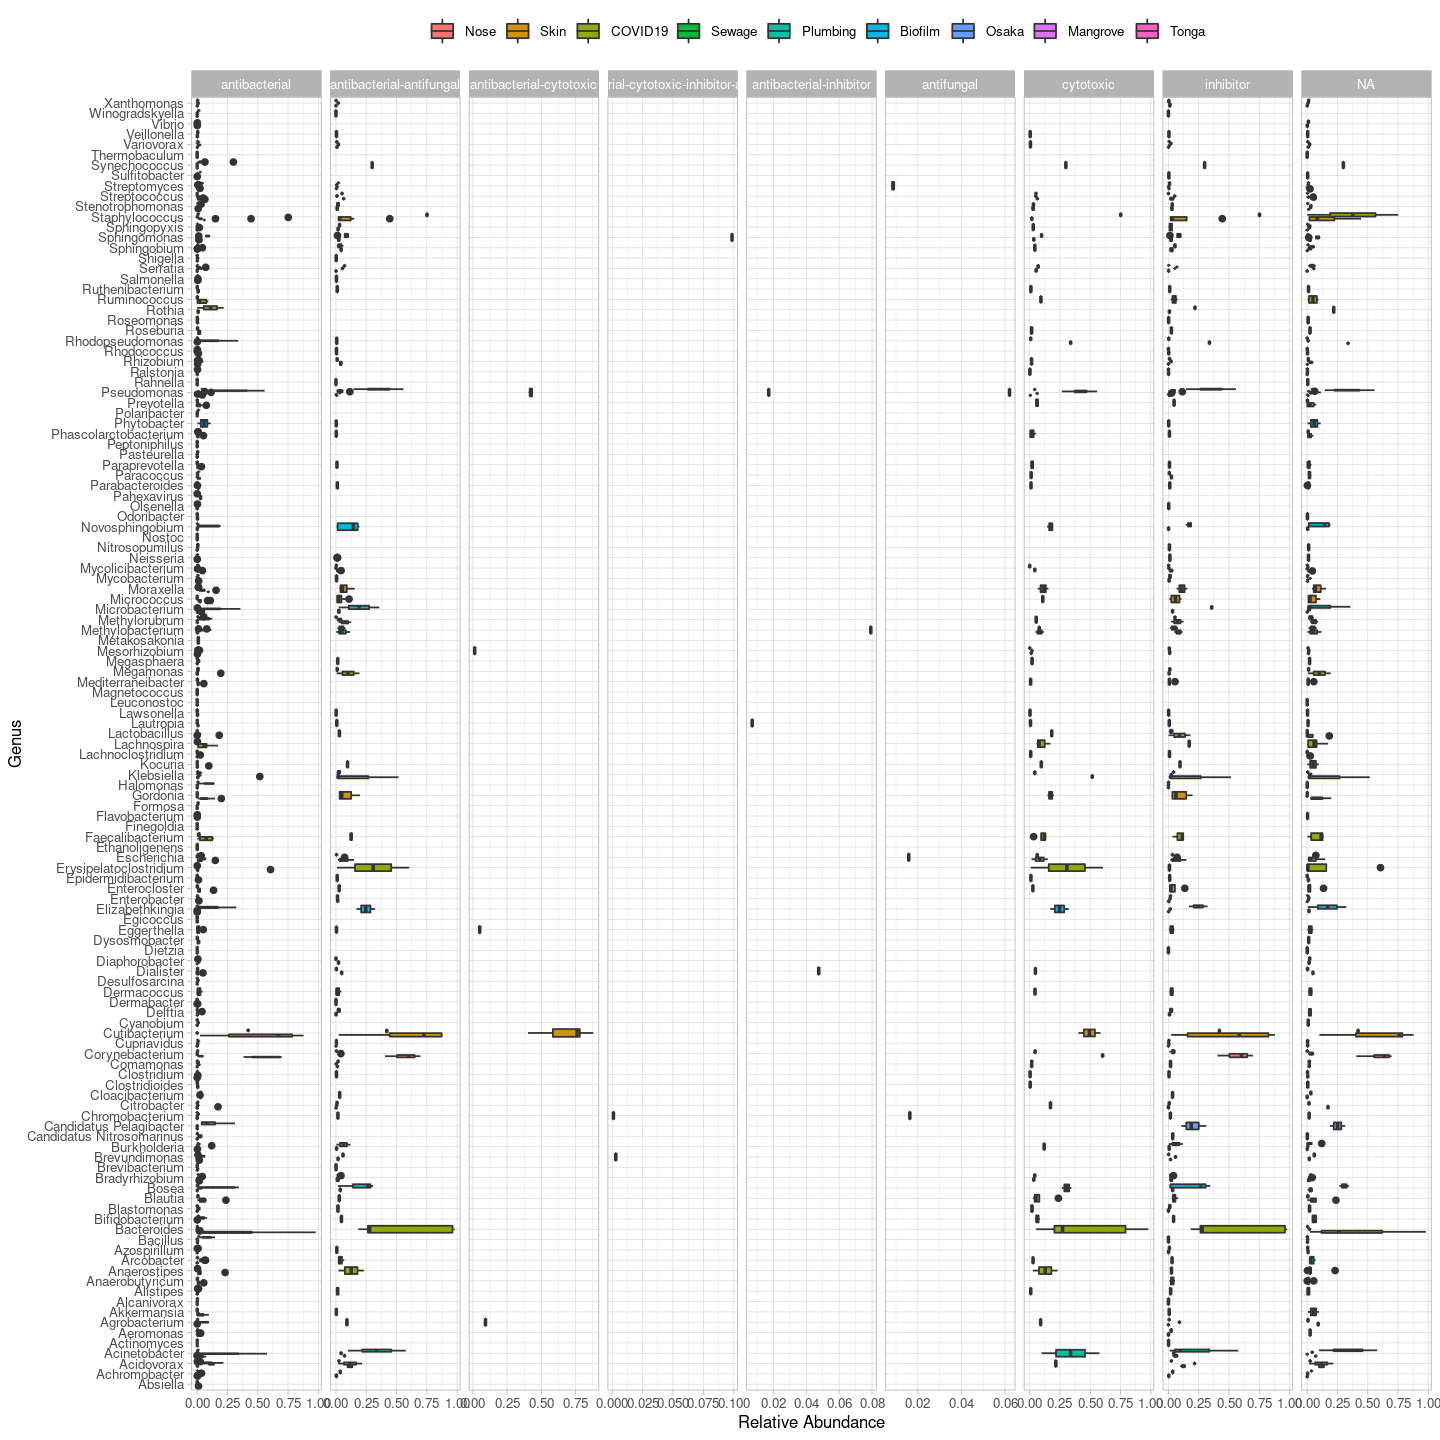

In [77]:
ggplot(deepbgc4) +
    geom_boxplot(aes(x = abundance, y = name, fill = project)) +
    theme_light(base_size = 10) +
    facet_wrap (~product_activity, scales = "free_x", nrow = 1) +
    labs (x = "Relative Abundance", y = "Genus", fill = "") +
    theme(legend.position = "top") +
    guides(fill = guide_legend(nrow = 1))
ggsave("figs/metaBGC_bgc_deepbgc_v2.pdf", width = 18, height = 18)